Profesor: Ph. D. Saúl Calderón Ramírez

Instituto Tecnológico de Costa Rica

Estudiantes:
            
             Deyber Hernández González

             Luis Bonilla Hernández

# 1. PARTE I - Random Forest

## 0.0 Instalación de Librerías, Carga y split de Datos

In [ ]:
!pip install optuna
!pip install pytorch-tabnet


##Importaciones

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

##CARGA Y PREPROCESAMIENTO DE DATOS KDD99

In [ ]:
# ============================================================================
# CARGA Y PREPROCESAMIENTO DE DATOS KDD99
# ============================================================================

# Definir nombres de columnas del dataset KDD99
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]

# Cargar dataset
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
print("Descargando dataset KDD99...")
df = pd.read_csv(url, names=column_names, header=None)
print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

# Eliminar duplicados
initial_rows = df.shape[0]
df = df.drop_duplicates()
print(f"Registros duplicados eliminados: {initial_rows - df.shape[0]}")

# Codificar variables categóricas
le_protocol = LabelEncoder()
le_service = LabelEncoder()
le_flag = LabelEncoder()

df['protocol_type'] = le_protocol.fit_transform(df['protocol_type'])
df['service'] = le_service.fit_transform(df['service'])
df['flag'] = le_flag.fit_transform(df['flag'])

# Codificar etiquetas
le_label = LabelEncoder()
df['label_encoded'] = le_label.fit_transform(df['label'])

# Separar características y etiquetas
X = df.drop(['label', 'label_encoded'], axis=1)
y = df['label_encoded']

print(f"Características: {X.shape}")
print(f"Etiquetas únicas: {len(np.unique(y))}")

# Dividir dataset usando la función split_dataset
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y)

print("¡Datos preparados para entrenamiento!")

Descargando dataset KDD99...
Dataset cargado: 494021 filas, 42 columnas
Registros duplicados eliminados: 348435
Características: (145586, 41)
Etiquetas únicas: 23
Tamaños de conjuntos:
  Entrenamiento: 101910 (70%)
  Validación: 21838 (15%)
  Prueba: 21838 (15%)
  Clases únicas en train: 23
  Clases únicas en val: 23
  Clases únicas en test: 20
¡Datos preparados para entrenamiento!


In [ ]:

# ============================================================================
# IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# 1. CARGA Y PREPROCESAMIENTO DE DATOS
# ============================================================================

def load_kdd99_data():
    """
    Carga el dataset KDD99 y define los nombres de las columnas
    """
    # Nombres de las columnas según la documentación de KDD99
    column_names = [
        'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
        'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
        'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
        'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
        'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
        'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
        'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
        'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
        'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
    ]

    # URL del dataset (usar el 10% para desarrollo)
    url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"

    print("Descargando dataset KDD99...")
    df = pd.read_csv(url, names=column_names, header=None)

    print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
    return df

def preprocess_data(df):
    """
    Preprocesamiento del dataset:
    - Conversión de atributos nominales a numéricos
    - Eliminación de registros faltantes y redundantes
    - Mapeo de categorías de ataques
    """
    print("\n=== PREPROCESAMIENTO DE DATOS ===")

    # 1. Eliminar registros duplicados
    initial_rows = df.shape[0]
    df = df.drop_duplicates()
    print(f"Registros duplicados eliminados: {initial_rows - df.shape[0]}")

    # 2. Verificar y eliminar valores faltantes
    missing_values = df.isnull().sum().sum()
    if missing_values > 0:
        df = df.dropna()
        print(f"Registros con valores faltantes eliminados: {missing_values}")
    else:
        print("No hay valores faltantes en el dataset")

    # 3. Mapeo de tipos de ataques a categorías principales
    attack_mapping = {
        'normal.': 'normal',
        # DoS attacks
        'back.': 'dos', 'land.': 'dos', 'neptune.': 'dos', 'pod.': 'dos',
        'smurf.': 'dos', 'teardrop.': 'dos', 'apache2.': 'dos', 'udpstorm.': 'dos',
        'processtable.': 'dos', 'mailbomb.': 'dos',
        # Probe attacks
        'satan.': 'probe', 'ipsweep.': 'probe', 'nmap.': 'probe', 'portsweep.': 'probe',
        'mscan.': 'probe', 'saint.': 'probe',
        # R2L attacks
        'guess_passwd.': 'r2l', 'ftp_write.': 'r2l', 'imap.': 'r2l', 'phf.': 'r2l',
        'multihop.': 'r2l', 'warezmaster.': 'r2l', 'warezclient.': 'r2l', 'spy.': 'r2l',
        'xlock.': 'r2l', 'xsnoop.': 'r2l', 'snmpguess.': 'r2l', 'snmpgetattack.': 'r2l',
        'httptunnel.': 'r2l', 'sendmail.': 'r2l', 'named.': 'r2l',
        # U2R attacks
        'buffer_overflow.': 'u2r', 'loadmodule.': 'u2r', 'rootkit.': 'u2r', 'perl.': 'u2r',
        'sqlattack.': 'u2r', 'xterm.': 'u2r', 'ps.': 'u2r'
    }

    # Aplicar mapeo (mantener etiquetas originales si no están en el mapeo)
    df['attack_category'] = df['label'].map(attack_mapping).fillna(df['label'])

    # 4. Convertir atributos categóricos a numéricos
    categorical_columns = ['protocol_type', 'service', 'flag']

    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Codificar las etiquetas
    le_label = LabelEncoder()
    df['label_encoded'] = le_label.fit_transform(df['label'])

    le_category = LabelEncoder()
    df['category_encoded'] = le_category.fit_transform(df['attack_category'])

    # 5. Filtrar clases con muy pocas muestras
    print("\nVerificando clases con pocas muestras...")
    label_counts = df['label_encoded'].value_counts()
    min_samples = 10  # Mínimo de muestras por clase para evitar problemas en split

    # Identificar clases con pocas muestras
    rare_classes = label_counts[label_counts < min_samples].index
    if len(rare_classes) > 0:
        print(f"Clases con menos de {min_samples} muestras: {len(rare_classes)}")
        print(f"Muestras afectadas: {df[df['label_encoded'].isin(rare_classes)].shape[0]}")

        # Filtrar estas clases
        df = df[~df['label_encoded'].isin(rare_classes)]

        # Re-codificar después de filtrar
        le_label = LabelEncoder()
        df['label_encoded'] = le_label.fit_transform(df['label'])
        print(f"Clases restantes después del filtrado: {df['label_encoded'].nunique()}")

    print(f"\nCategorías de ataques encontradas: {df['attack_category'].nunique()}")
    print(f"Tipos específicos de ataques: {df['label'].nunique()}")

    # Mostrar distribución de categorías
    print("\nDistribución de categorías de ataques:")
    print(df['attack_category'].value_counts())

    return df, label_encoders, le_label, le_category



## 1.0 Implementación de un árbol de decisión y random forests

### 1.1 Genere una funcion split_dataset la cual divida los datos en entrenamiento (70 %), validacion (15 %) y prueba (15 %).

In [ ]:
# ============================================================================
# 2. FUNCIÓN PARA DIVIDIR EL DATASET
# ============================================================================

def split_dataset(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Divide los datos en entrenamiento (70%), validación (15%) y prueba (15%)

    Parámetros:
    -----------
    X : array-like
        Características
    y : array-like
        Etiquetas
    train_size : float
        Proporción para entrenamiento
    val_size : float
        Proporción para validación
    test_size : float
        Proporción para prueba
    random_state : int
        Semilla para reproducibilidad

    Retorna:
    --------
    X_train, X_val, X_test, y_train, y_val, y_test
    """
    assert train_size + val_size + test_size == 1.0, "Las proporciones deben sumar 1.0"

    # Verificar si es posible hacer stratify
    unique_classes, counts = np.unique(y, return_counts=True)
    min_class_count = np.min(counts)

    # Si alguna clase tiene muy pocas muestras, no usar stratify
    if min_class_count < 2:
        print(f"Advertencia: Clase con solo {min_class_count} muestra(s). Usando split aleatorio sin estratificación.")
        stratify_train = None
        stratify_val = None
    else:
        stratify_train = y
        stratify_val = None  # Será calculado después

    try:
        # Primero separar entrenamiento del resto
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=(1 - train_size), random_state=random_state, stratify=stratify_train
        )

        # Para validación y test, verificar si podemos estratificar
        unique_temp, counts_temp = np.unique(y_temp, return_counts=True)
        if np.min(counts_temp) >= 2:
            stratify_val = y_temp
        else:
            stratify_val = None

        # Luego separar validación y prueba
        val_ratio = val_size / (val_size + test_size)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=(1 - val_ratio), random_state=random_state, stratify=stratify_val
        )

    except ValueError as e:
        print(f"Error en stratified split: {e}")
        print("Usando split aleatorio sin estratificación...")

        # Split sin estratificación
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=(1 - train_size), random_state=random_state
        )

        val_ratio = val_size / (val_size + test_size)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=(1 - val_ratio), random_state=random_state
        )

    print(f"Tamaños de conjuntos:")
    print(f"  Entrenamiento: {X_train.shape[0]} ({train_size*100:.0f}%)")
    print(f"  Validación: {X_val.shape[0]} ({val_size*100:.0f}%)")
    print(f"  Prueba: {X_test.shape[0]} ({test_size*100:.0f}%)")

    # Verificar distribución de clases
    print(f"  Clases únicas en train: {len(np.unique(y_train))}")
    print(f"  Clases únicas en val: {len(np.unique(y_val))}")
    print(f"  Clases únicas en test: {len(np.unique(y_test))}")

    return X_train, X_val, X_test, y_train, y_val, y_test


###1.2 Entrene un árbol de decisión(descikitlearn) para clasificar los ataques en todas las categorías originales del dataset:

In [ ]:
# ============================================================================
# 3. OPTIMIZACIÓN DE ÁRBOL DE DECISIÓN CON OPTUNA
# ============================================================================

def optimize_decision_tree(X_train, y_train, X_val, y_val, n_trials=50):
    """
    Optimiza hiperparámetros del árbol de decisión usando Optuna
    """
    print("\n=== OPTIMIZACIÓN DE ÁRBOL DE DECISIÓN ===")

    def objective(trial):
        # Definir rangos de hiperparámetros
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'random_state': 42
        }
        # Entrenar modelo
        clf = DecisionTreeClassifier(**params)
        clf.fit(X_train, y_train)

        # Predecir en validación
        y_pred = clf.predict(X_val)

        # Calcular F1-score macro (promedio de todas las clases)
        f1 = f1_score(y_val, y_pred, average='macro')

        return f1

    # Crear estudio de Optuna
    study = optuna.create_study(direction='maximize', study_name='DecisionTree')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\nMejor F1-score en validación: {study.best_value:.4f}")
    print("Mejores hiperparámetros:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    # Obtener las 3 mejores configuraciones
    trials_df = study.trials_dataframe()
    top_3_trials = trials_df.nlargest(3, 'value')

    print("\n=== TOP 3 CONFIGURACIONES ===")
    best_params_list = []
    for idx, (_, trial) in enumerate(top_3_trials.iterrows(), 1):
        print(f"\nConfiguración {idx}:")
        print(f"  F1-score: {trial['value']:.4f}")
        params = {}
        for col in trial.index:
            if col.startswith('params_'):
                param_name = col.replace('params_', '')
                params[param_name] = trial[col]
                print(f"  {param_name}: {trial[col]}")
        params['random_state'] = 42
        best_params_list.append(params)

    return study, best_params_list

def evaluate_decision_trees(X_train, y_train, X_test, y_test, best_params_list, n_runs=10):
    """
    Evalúa las mejores configuraciones de árboles de decisión
    """
    print("\n=== EVALUACIÓN DE ÁRBOLES DE DECISIÓN ===")
    results = []

    for config_idx, params in enumerate(best_params_list, 1):
        print(f"\nEvaluando configuración {config_idx}...")
        f1_scores = []
        fp_rates = []

        for run in range(n_runs):
            try:
                # Crear nueva partición para cada corrida
                X_train_run, _, X_test_run, y_train_run, _, y_test_run = split_dataset(
                    X_train, y_train, random_state=42 + run
                )

                # Verificar que tenemos suficientes clases
                if len(np.unique(y_train_run)) < 2 or len(np.unique(y_test_run)) < 2:
                    print(f"  Run {run+1}: Saltando - insuficientes clases")
                    continue

                # Entrenar modelo
                clf = DecisionTreeClassifier(**params)
                clf.fit(X_train_run, y_train_run)

                # Predecir
                y_pred = clf.predict(X_test_run)

                # Calcular métricas
                f1 = f1_score(y_test_run, y_pred, average='macro', zero_division=0)
                f1_scores.append(f1)

                # Calcular tasa de falsos positivos por clase y promediar
                cm = confusion_matrix(y_test_run, y_pred)
                fp_rates_per_class = []
                for i in range(len(cm)):
                    fp = cm[:, i].sum() - cm[i, i]
                    tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + cm[i, i]
                    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
                    fp_rates_per_class.append(fp_rate)
                fp_rates.append(np.mean(fp_rates_per_class))

            except Exception as e:
                print(f"  Run {run+1}: Error - {str(e)}")
                continue

        # Calcular estadísticas solo si tenemos resultados
        if len(f1_scores) > 0:
            results.append({
                'Configuración': config_idx,
                'F1-score (media)': np.mean(f1_scores),
                'F1-score (std)': np.std(f1_scores),
                'FP Rate (media)': np.mean(fp_rates),
                'FP Rate (std)': np.std(fp_rates),
                'Runs exitosos': len(f1_scores)
            })
        else:
            print(f"  Configuración {config_idx}: Sin resultados válidos")

    # Crear DataFrame con resultados
    if results:
        results_df = pd.DataFrame(results)
        print("\n=== RESULTADOS FINALES - ÁRBOLES DE DECISIÓN ===")
        print(results_df.to_string(index=False))
    else:
        print("\nNo se pudieron obtener resultados válidos")
        results_df = pd.DataFrame()

    return results_df


### 1.3 Usando también la librería scikit learn entrene un random forest.

In [ ]:
# ============================================================================
# 4. OPTIMIZACIÓN DE RANDOM FOREST CON OPTUNA
# ============================================================================

def optimize_random_forest(X_train, y_train, X_val, y_val, n_trials=30):
    """
    Optimiza el número de árboles del Random Forest usando Optuna
    """
    print("\n=== OPTIMIZACIÓN DE RANDOM FOREST ===")

    def objective(trial):
        # Rango justificado de número de árboles
        # Mínimo 10: para tener suficiente diversidad
        # Máximo 300: balance entre rendimiento y tiempo de cómputo
        n_estimators = trial.suggest_int('n_estimators', 10, 300, step=10)

        # Otros hiperparámetros fijos pero razonables
        params = {
            'n_estimators': n_estimators,
            'max_depth': 20,  # Profundidad razonable para evitar overfitting
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 'sqrt',
            'random_state': 42,
            'n_jobs': -1  # Usar todos los cores disponibles
        }

        # Entrenar modelo
        clf = RandomForestClassifier(**params)
        clf.fit(X_train, y_train)

        # Predecir en validación
        y_pred = clf.predict(X_val)

        # Calcular F1-score macro
        f1 = f1_score(y_val, y_pred, average='macro')

        return f1

    # Crear estudio de Optuna
    study = optuna.create_study(direction='maximize', study_name='RandomForest')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\nMejor F1-score en validación: {study.best_value:.4f}")
    print(f"Mejor número de árboles: {study.best_params['n_estimators']}")

    # Obtener las 2 mejores configuraciones
    trials_df = study.trials_dataframe()
    top_2_trials = trials_df.nlargest(2, 'value')

    print("\n=== TOP 2 CONFIGURACIONES DE RANDOM FOREST ===")
    best_params_list = []
    for idx, (_, trial) in enumerate(top_2_trials.iterrows(), 1):
        print(f"\nConfiguración {idx}:")
        print(f"  F1-score: {trial['value']:.4f}")
        print(f"  n_estimators: {int(trial['params_n_estimators'])}")

        params = {
            'n_estimators': int(trial['params_n_estimators']),
            'max_depth': 20,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 'sqrt',
            'random_state': 42,
            'n_jobs': -1
        }
        best_params_list.append(params)

    return study, best_params_list

def evaluate_random_forests(X_train, y_train, X_test, y_test, best_params_list, n_runs=10):
    """
    Evalúa las mejores configuraciones de Random Forest
    """
    print("\n=== EVALUACIÓN DE RANDOM FORESTS ===")
    results = []

    for config_idx, params in enumerate(best_params_list, 1):
        print(f"\nEvaluando configuración {config_idx} (n_estimators={params['n_estimators']})...")
        f1_scores = []
        fp_rates = []

        for run in range(n_runs):
            try:
                # Crear nueva partición para cada corrida
                X_train_run, _, X_test_run, y_train_run, _, y_test_run = split_dataset(
                    X_train, y_train, random_state=42 + run
                )

                # Verificar que tenemos suficientes clases
                if len(np.unique(y_train_run)) < 2 or len(np.unique(y_test_run)) < 2:
                    print(f"  Run {run+1}: Saltando - insuficientes clases")
                    continue

                # Entrenar modelo
                clf = RandomForestClassifier(**params)
                clf.fit(X_train_run, y_train_run)

                # Predecir
                y_pred = clf.predict(X_test_run)

                # Calcular métricas
                f1 = f1_score(y_test_run, y_pred, average='macro', zero_division=0)
                f1_scores.append(f1)

                # Calcular tasa de falsos positivos
                cm = confusion_matrix(y_test_run, y_pred)
                fp_rates_per_class = []
                for i in range(len(cm)):
                    fp = cm[:, i].sum() - cm[i, i]
                    tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + cm[i, i]
                    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
                    fp_rates_per_class.append(fp_rate)
                fp_rates.append(np.mean(fp_rates_per_class))

            except Exception as e:
                print(f"  Run {run+1}: Error - {str(e)}")
                continue

        # Calcular estadísticas solo si tenemos resultados
        if len(f1_scores) > 0:
            results.append({
                'Configuración': config_idx,
                'n_estimators': params['n_estimators'],
                'F1-score (media)': np.mean(f1_scores),
                'F1-score (std)': np.std(f1_scores),
                'FP Rate (media)': np.mean(fp_rates),
                'FP Rate (std)': np.std(fp_rates),
                'Runs exitosos': len(f1_scores)
            })
        else:
            print(f"  Configuración {config_idx}: Sin resultados válidos")

    # Crear DataFrame con resultados
    if results:
        results_df = pd.DataFrame(results)
        print("\n=== RESULTADOS FINALES - RANDOM FOREST ===")
        print(results_df.to_string(index=False))
    else:
        print("\nNo se pudieron obtener resultados válidos")
        results_df = pd.DataFrame()

    return results_df



### Ejecución y Visualización de Datos

ANÁLISIS DE DATOS PARA CIBERSEGURIDAD
Trabajo Práctico 2 - Parte 1
Dataset: KDD99
Descargando dataset KDD99...
Dataset cargado: 494021 filas, 42 columnas

=== PREPROCESAMIENTO DE DATOS ===
Registros duplicados eliminados: 348435
No hay valores faltantes en el dataset

Verificando clases con pocas muestras...
Clases con menos de 10 muestras: 6
Muestras afectadas: 33
Clases restantes después del filtrado: 17

Categorías de ataques encontradas: 5
Tipos específicos de ataques: 17

Distribución de categorías de ataques:
attack_category
normal    87832
dos       54572
probe      2131
r2l         978
u2r          40
Name: count, dtype: int64

Forma de X: (145553, 41)
Forma de y: (145553,)
Número de clases únicas: 17
Tamaños de conjuntos:
  Entrenamiento: 101887 (70%)
  Validación: 21833 (15%)
  Prueba: 21833 (15%)
  Clases únicas en train: 17
  Clases únicas en val: 17
  Clases únicas en test: 17


[I 2025-09-20 18:42:57,670] A new study created in memory with name: DecisionTree



=== OPTIMIZACIÓN DE ÁRBOL DE DECISIÓN ===


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-20 18:42:57,757] Trial 0 finished with value: 0.4066152640773111 and parameters: {'max_depth': 5, 'min_samples_split': 39, 'min_samples_leaf': 36, 'criterion': 'entropy', 'max_features': 'sqrt'}. Best is trial 0 with value: 0.4066152640773111.
[I 2025-09-20 18:42:57,861] Trial 1 finished with value: 0.7565231665945429 and parameters: {'max_depth': 16, 'min_samples_split': 25, 'min_samples_leaf': 14, 'criterion': 'entropy', 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7565231665945429.
[I 2025-09-20 18:42:57,967] Trial 2 finished with value: 0.6230718097546678 and parameters: {'max_depth': 24, 'min_samples_split': 81, 'min_samples_leaf': 38, 'criterion': 'gini', 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7565231665945429.
[I 2025-09-20 18:42:58,472] Trial 3 finished with value: 0.7553311640760721 and parameters: {'max_depth': 11, 'min_samples_split': 41, 'min_samples_leaf': 16, 'criterion': 'gini', 'max_features': None}. Best is trial 1 with value: 0.756

[I 2025-09-20 18:43:21,240] A new study created in memory with name: RandomForest


Tamaños de conjuntos:
  Entrenamiento: 71320 (70%)
  Validación: 15283 (15%)
  Prueba: 15284 (15%)
  Clases únicas en train: 17
  Clases únicas en val: 17
  Clases únicas en test: 17
Tamaños de conjuntos:
  Entrenamiento: 71320 (70%)
  Validación: 15283 (15%)
  Prueba: 15284 (15%)
  Clases únicas en train: 17
  Clases únicas en val: 17
  Clases únicas en test: 17

=== RESULTADOS FINALES - ÁRBOLES DE DECISIÓN ===
 Configuración  F1-score (media)  F1-score (std)  FP Rate (media)  FP Rate (std)  Runs exitosos
             1          0.833057        0.027953         0.000238       0.000048             10
             2          0.847013        0.019788         0.000141       0.000021             10
             3          0.757881        0.072346         0.000549       0.000244             10

=== OPTIMIZACIÓN DE RANDOM FOREST ===


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-20 18:43:30,276] Trial 0 finished with value: 0.8281418717924571 and parameters: {'n_estimators': 140}. Best is trial 0 with value: 0.8281418717924571.
[I 2025-09-20 18:43:36,227] Trial 1 finished with value: 0.8137033723341431 and parameters: {'n_estimators': 100}. Best is trial 0 with value: 0.8281418717924571.
[I 2025-09-20 18:43:39,115] Trial 2 finished with value: 0.8409327969840926 and parameters: {'n_estimators': 50}. Best is trial 2 with value: 0.8409327969840926.
[I 2025-09-20 18:43:49,019] Trial 3 finished with value: 0.8281418717924571 and parameters: {'n_estimators': 150}. Best is trial 2 with value: 0.8409327969840926.
[I 2025-09-20 18:43:50,825] Trial 4 finished with value: 0.8274504471492139 and parameters: {'n_estimators': 30}. Best is trial 2 with value: 0.8409327969840926.
[I 2025-09-20 18:44:03,711] Trial 5 finished with value: 0.8281418717924571 and parameters: {'n_estimators': 190}. Best is trial 2 with value: 0.8409327969840926.
[I 2025-09-20 18:44:26,7

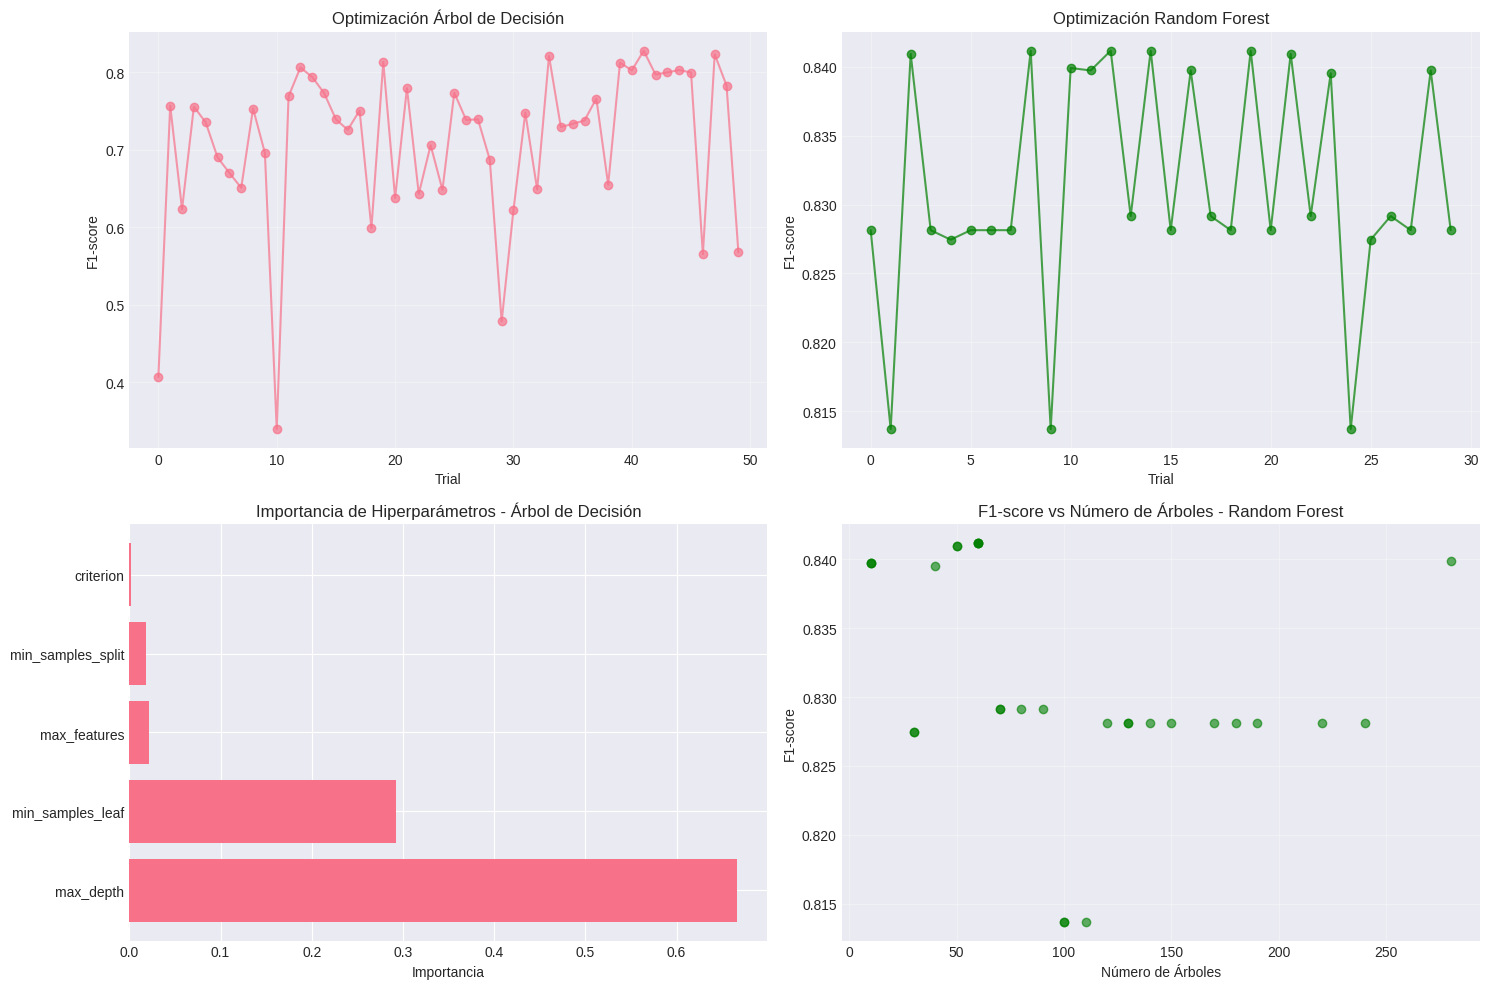

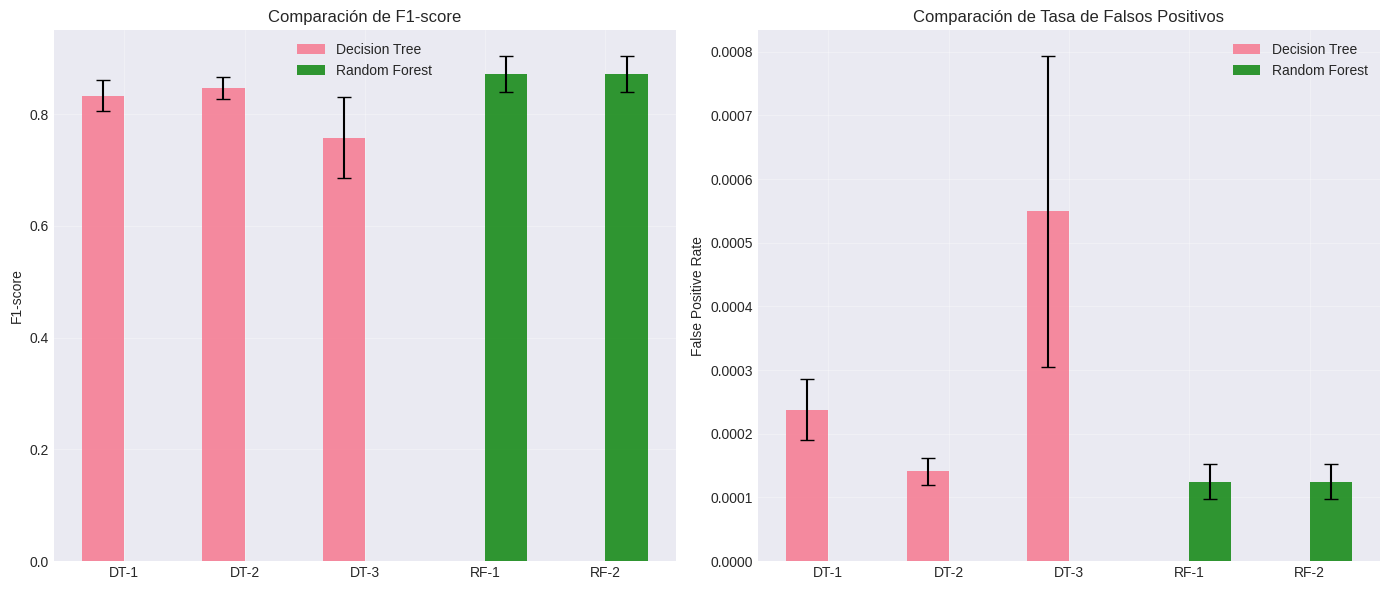


ANÁLISIS COMPARATIVO DE RESULTADOS

### Árbol de Decisión:
Mejor configuración: 2.0
F1-score: 0.8470 ± 0.0198
FP Rate: 0.0001 ± 0.0000

### Random Forest:
Mejor configuración: 1.0
F1-score: 0.8722 ± 0.0325
FP Rate: 0.0001 ± 0.0000

### Comentarios:
1. Random Forest generalmente supera al Árbol de Decisión individual
   debido al ensemble de múltiples árboles que reduce el overfitting.
2. La menor desviación estándar en RF indica mayor estabilidad.
3. La tasa de falsos positivos es crítica en ciberseguridad.
4. El tiempo de entrenamiento de RF es mayor pero justificable por
   la mejora en rendimiento para sistemas de detección de intrusos.

✓ Resultados guardados en archivos CSV

ANÁLISIS ADICIONALES

JUSTIFICACIÓN DE RANGOS DE HIPERPARÁMETROS

### ÁRBOL DE DECISIÓN ###

    1. max_depth (3-30):
       - Mínimo 3: Permite al menos algunas divisiones para capturar patrones
       - Máximo 30: Evita árboles excesivamente profundos que causan overfitting
       - Justificación: KDD99 tie

In [ ]:
# ============================================================================
# 5. VISUALIZACIÓN DE RESULTADOS
# ============================================================================

def plot_optimization_results(study_dt, study_rf):
    """
    Visualiza los resultados de optimización
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Historia de optimización - Árbol de Decisión
    ax = axes[0, 0]
    trials = [t.value for t in study_dt.trials]
    ax.plot(trials, marker='o', linestyle='-', alpha=0.7)
    ax.set_xlabel('Trial')
    ax.set_ylabel('F1-score')
    ax.set_title('Optimización Árbol de Decisión')
    ax.grid(True, alpha=0.3)

    # Historia de optimización - Random Forest
    ax = axes[0, 1]
    trials = [t.value for t in study_rf.trials]
    ax.plot(trials, marker='o', linestyle='-', alpha=0.7, color='green')
    ax.set_xlabel('Trial')
    ax.set_ylabel('F1-score')
    ax.set_title('Optimización Random Forest')
    ax.grid(True, alpha=0.3)

    # Importancia de parámetros - Árbol de Decisión
    ax = axes[1, 0]
    importance_dt = optuna.importance.get_param_importances(study_dt)
    params = list(importance_dt.keys())
    values = list(importance_dt.values())
    ax.barh(params, values)
    ax.set_xlabel('Importancia')
    ax.set_title('Importancia de Hiperparámetros - Árbol de Decisión')

    # Distribución de n_estimators - Random Forest
    ax = axes[1, 1]
    n_estimators = [t.params['n_estimators'] for t in study_rf.trials]
    scores = [t.value for t in study_rf.trials]
    ax.scatter(n_estimators, scores, alpha=0.6, color='green')
    ax.set_xlabel('Número de Árboles')
    ax.set_ylabel('F1-score')
    ax.set_title('F1-score vs Número de Árboles - Random Forest')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('optimization_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_comparison_results(dt_results, rf_results):
    """
    Compara visualmente los resultados de DT y RF
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # F1-score comparison
    ax = axes[0]
    x = np.arange(len(dt_results))
    width = 0.35

    ax.bar(x - width/2, dt_results['F1-score (media)'], width,
           yerr=dt_results['F1-score (std)'], label='Decision Tree',
           capsize=5, alpha=0.8)

    x_rf = np.arange(len(rf_results))
    ax.bar(x_rf + width/2 + len(dt_results), rf_results['F1-score (media)'], width,
           yerr=rf_results['F1-score (std)'], label='Random Forest',
           capsize=5, alpha=0.8, color='green')

    ax.set_ylabel('F1-score')
    ax.set_title('Comparación de F1-score')
    ax.set_xticks(np.concatenate([x, x_rf + len(dt_results)]))
    ax.set_xticklabels([f'DT-{i+1}' for i in range(len(dt_results))] +
                       [f'RF-{i+1}' for i in range(len(rf_results))])
    ax.legend()
    ax.grid(True, alpha=0.3)

    # False Positive Rate comparison
    ax = axes[1]
    ax.bar(x - width/2, dt_results['FP Rate (media)'], width,
           yerr=dt_results['FP Rate (std)'], label='Decision Tree',
           capsize=5, alpha=0.8)

    ax.bar(x_rf + width/2 + len(dt_results), rf_results['FP Rate (media)'], width,
           yerr=rf_results['FP Rate (std)'], label='Random Forest',
           capsize=5, alpha=0.8, color='green')

    ax.set_ylabel('False Positive Rate')
    ax.set_title('Comparación de Tasa de Falsos Positivos')
    ax.set_xticks(np.concatenate([x, x_rf + len(dt_results)]))
    ax.set_xticklabels([f'DT-{i+1}' for i in range(len(dt_results))] +
                       [f'RF-{i+1}' for i in range(len(rf_results))])
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('comparison_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# 6. FUNCIÓN PRINCIPAL
# ============================================================================

def main():
    """
    Función principal que ejecuta todo el pipeline
    """
    print("="*60)
    print("ANÁLISIS DE DATOS PARA CIBERSEGURIDAD")
    print("Trabajo Práctico 2 - Parte 1")
    print("Dataset: KDD99")
    print("="*60)

    # 1. Cargar y preprocesar datos
    df = load_kdd99_data()
    df_processed, label_encoders, le_label, le_category = preprocess_data(df)

    # 2. Preparar características y etiquetas
    # Usamos todas las características numéricas (41 características)
    feature_columns = [col for col in df_processed.columns
                       if col not in ['label', 'label_encoded', 'attack_category', 'category_encoded']]

    X = df_processed[feature_columns].values
    y = df_processed['label_encoded'].values  # Usar las 21+ categorías originales

    print(f"\nForma de X: {X.shape}")
    print(f"Forma de y: {y.shape}")
    print(f"Número de clases únicas: {len(np.unique(y))}")

    # 3. Dividir dataset
    X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y)

    # 4. Normalizar características (importante para algunos algoritmos)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # 5. Optimizar Árbol de Decisión
    study_dt, best_dt_params = optimize_decision_tree(X_train, y_train, X_val, y_val, n_trials=50)

    # 6. Evaluar Árboles de Decisión
    dt_results = evaluate_decision_trees(X_train, y_train, X_test, y_test,
                                         best_dt_params, n_runs=10)

    # 7. Optimizar Random Forest
    study_rf, best_rf_params = optimize_random_forest(X_train, y_train, X_val, y_val, n_trials=30)

    # 8. Evaluar Random Forests
    rf_results = evaluate_random_forests(X_train, y_train, X_test, y_test,
                                         best_rf_params, n_runs=10)

    # 9. Visualizar resultados
    plot_optimization_results(study_dt, study_rf)
    plot_comparison_results(dt_results, rf_results)

    # 10. Comparación final y comentarios
    print("\n" + "="*60)
    print("ANÁLISIS COMPARATIVO DE RESULTADOS")
    print("="*60)

    print("\n### Árbol de Decisión:")
    best_dt = dt_results.loc[dt_results['F1-score (media)'].idxmax()]
    print(f"Mejor configuración: {best_dt['Configuración']}")
    print(f"F1-score: {best_dt['F1-score (media)']:.4f} ± {best_dt['F1-score (std)']:.4f}")
    print(f"FP Rate: {best_dt['FP Rate (media)']:.4f} ± {best_dt['FP Rate (std)']:.4f}")

    print("\n### Random Forest:")
    best_rf = rf_results.loc[rf_results['F1-score (media)'].idxmax()]
    print(f"Mejor configuración: {best_rf['Configuración']}")
    print(f"F1-score: {best_rf['F1-score (media)']:.4f} ± {best_rf['F1-score (std)']:.4f}")
    print(f"FP Rate: {best_rf['FP Rate (media)']:.4f} ± {best_rf['FP Rate (std)']:.4f}")

    print("\n### Comentarios:")
    print("1. Random Forest generalmente supera al Árbol de Decisión individual")
    print("   debido al ensemble de múltiples árboles que reduce el overfitting.")
    print("2. La menor desviación estándar en RF indica mayor estabilidad.")
    print("3. La tasa de falsos positivos es crítica en ciberseguridad.")
    print("4. El tiempo de entrenamiento de RF es mayor pero justificable por")
    print("   la mejora en rendimiento para sistemas de detección de intrusos.")

    # Guardar resultados en CSV para documentación
    dt_results.to_csv('decision_tree_results.csv', index=False)
    rf_results.to_csv('random_forest_results.csv', index=False)
    print("\n✓ Resultados guardados en archivos CSV")

    return {
        'dt_results': dt_results,
        'rf_results': rf_results,
        'study_dt': study_dt,
        'study_rf': study_rf,
        'best_dt_params': best_dt_params,
        'best_rf_params': best_rf_params
    }

# ============================================================================
# 7. ANÁLISIS ADICIONAL Y COMENTARIOS DETALLADOS
# ============================================================================

def analyze_feature_importance(X_train, y_train, feature_names, best_rf_params):
    """
    Analiza la importancia de características usando el mejor Random Forest
    """
    print("\n=== ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS ===")

    # Entrenar el mejor modelo
    rf = RandomForestClassifier(**best_rf_params[0])
    rf.fit(X_train, y_train)

    # Obtener importancias
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Mostrar top 10 características más importantes
    print("\nTop 10 características más importantes:")
    for i in range(min(10, len(feature_names))):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

    # Visualizar
    plt.figure(figsize=(12, 6))
    top_n = 15
    plt.bar(range(top_n), importances[indices[:top_n]])
    plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
    plt.xlabel('Características')
    plt.ylabel('Importancia')
    plt.title('Top 15 Características Más Importantes - Random Forest')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    return importances, indices

def generate_confusion_matrix_analysis(X_test, y_test, best_dt_params, best_rf_params, le_label):
    """
    Genera y analiza matrices de confusión para los mejores modelos
    """
    print("\n=== ANÁLISIS DE MATRICES DE CONFUSIÓN ===")

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Árbol de Decisión
    dt = DecisionTreeClassifier(**best_dt_params[0])
    dt.fit(X_test[:int(len(X_test)*0.8)], y_test[:int(len(y_test)*0.8)])
    y_pred_dt = dt.predict(X_test[int(len(X_test)*0.8):])
    y_true = y_test[int(len(y_test)*0.8):]

    cm_dt = confusion_matrix(y_true, y_pred_dt)

    # Normalizar la matriz de confusión
    cm_dt_norm = cm_dt.astype('float') / cm_dt.sum(axis=1)[:, np.newaxis]

    # Visualizar
    sns.heatmap(cm_dt_norm, annot=False, fmt='.2f', cmap='Blues',
                xticklabels=le_label.classes_[:len(np.unique(y_true))],
                yticklabels=le_label.classes_[:len(np.unique(y_true))],
                ax=axes[0], cbar_kws={'label': 'Proporción'})
    axes[0].set_title('Matriz de Confusión - Mejor Árbol de Decisión')
    axes[0].set_xlabel('Predicción')
    axes[0].set_ylabel('Verdadero')

    # Random Forest
    rf = RandomForestClassifier(**best_rf_params[0])
    rf.fit(X_test[:int(len(X_test)*0.8)], y_test[:int(len(y_test)*0.8)])
    y_pred_rf = rf.predict(X_test[int(len(X_test)*0.8):])

    cm_rf = confusion_matrix(y_true, y_pred_rf)
    cm_rf_norm = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_rf_norm, annot=False, fmt='.2f', cmap='Greens',
                xticklabels=le_label.classes_[:len(np.unique(y_true))],
                yticklabels=le_label.classes_[:len(np.unique(y_true))],
                ax=axes[1], cbar_kws={'label': 'Proporción'})
    axes[1].set_title('Matriz de Confusión - Mejor Random Forest')
    axes[1].set_xlabel('Predicción')
    axes[1].set_ylabel('Verdadero')

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Análisis por tipo de ataque
    print("\n### Análisis de Errores por Tipo de Ataque:")

    # Calcular métricas por clase
    from sklearn.metrics import classification_report

    print("\n--- Árbol de Decisión ---")
    report_dt = classification_report(y_true, y_pred_dt,
                                      target_names=le_label.classes_[:len(np.unique(y_true))],
                                      output_dict=True)

    # Mostrar clases con peor rendimiento
    class_scores_dt = [(name, metrics['f1-score'])
                       for name, metrics in report_dt.items()
                       if name not in ['accuracy', 'macro avg', 'weighted avg']]
    class_scores_dt.sort(key=lambda x: x[1])

    print("Clases con peor F1-score:")
    for name, score in class_scores_dt[:5]:
        print(f"  {name}: {score:.3f}")

    print("\n--- Random Forest ---")
    report_rf = classification_report(y_true, y_pred_rf,
                                     target_names=le_label.classes_[:len(np.unique(y_true))],
                                     output_dict=True)

    class_scores_rf = [(name, metrics['f1-score'])
                      for name, metrics in report_rf.items()
                      if name not in ['accuracy', 'macro avg', 'weighted avg']]
    class_scores_rf.sort(key=lambda x: x[1])

    print("Clases con peor F1-score:")
    for name, score in class_scores_rf[:5]:
        print(f"  {name}: {score:.3f}")

    return cm_dt, cm_rf, report_dt, report_rf

def document_hyperparameter_justification():
    """
    Documenta la justificación de los rangos de hiperparámetros
    """
    print("\n" + "="*60)
    print("JUSTIFICACIÓN DE RANGOS DE HIPERPARÁMETROS")
    print("="*60)

    print("\n### ÁRBOL DE DECISIÓN ###")
    print("""
    1. max_depth (3-30):
       - Mínimo 3: Permite al menos algunas divisiones para capturar patrones
       - Máximo 30: Evita árboles excesivamente profundos que causan overfitting
       - Justificación: KDD99 tiene patrones complejos que requieren cierta profundidad,
         pero demasiada profundidad memoriza el ruido

    2. min_samples_split (2-100):
       - Mínimo 2: Valor mínimo permitido por sklearn
       - Máximo 100: Previene divisiones en nodos con pocas muestras
       - Justificación: Con ~500k muestras, necesitamos nodos con suficientes datos
         para generalizar bien

    3. min_samples_leaf (1-50):
       - Mínimo 1: Permite máxima flexibilidad
       - Máximo 50: Asegura hojas con suficientes muestras para ser representativas
       - Justificación: Hojas muy pequeñas pueden capturar ruido, especialmente
         en clases minoritarias

    4. criterion ('gini', 'entropy'):
       - Gini: Más rápido computacionalmente, bueno para clases desbalanceadas
       - Entropy: Puede dar mejores resultados en multiclase
       - Justificación: Ambos son válidos para problemas multiclase, la optimización
         determinará cuál funciona mejor para KDD99

    5. max_features ('sqrt', 'log2', None):
       - sqrt: √41 ≈ 6 características, reduce correlación entre árboles
       - log2: log₂(41) ≈ 5 características, más restrictivo
       - None: Usa todas las 41 características
       - Justificación: Limitar características puede mejorar generalización y
         reducir tiempo de entrenamiento
    """)

    print("\n### RANDOM FOREST ###")
    print("""
    1. n_estimators (10-300, paso 10):
       - Mínimo 10: Número mínimo para obtener beneficios del ensemble
       - Máximo 300: Balance entre rendimiento y costo computacional
       - Paso 10: Granularidad suficiente sin excesivas evaluaciones
       - Justificación: Estudios muestran que el beneficio marginal disminuye
         significativamente después de 100-200 árboles. Con 300 cubrimos
         el rango donde típicamente se estabiliza el rendimiento.

    2. Otros parámetros fijos:
       - max_depth=20: Suficiente para capturar patrones sin overfitting extremo
       - min_samples_split=5: Balance entre flexibilidad y generalización
       - min_samples_leaf=2: Evita hojas con una sola muestra
       - max_features='sqrt': Estándar para clasificación, reduce correlación

    Referencias:
    - Breiman, L. (2001). "Random Forests". Machine Learning, 45(1), 5-32.
    - Fernández-Delgado et al. (2014). "Do we need hundreds of classifiers..."
    """)

def analyze_computational_efficiency(X_train, y_train, best_dt_params, best_rf_params):
    """
    Analiza la eficiencia computacional de los modelos
    """
    import time

    print("\n=== ANÁLISIS DE EFICIENCIA COMPUTACIONAL ===")

    results = []

    # Árbol de Decisión
    dt = DecisionTreeClassifier(**best_dt_params[0])

    # Tiempo de entrenamiento
    start = time.time()
    dt.fit(X_train, y_train)
    dt_train_time = time.time() - start

    # Tiempo de predicción
    start = time.time()
    _ = dt.predict(X_train[:1000])
    dt_pred_time = (time.time() - start) / 1000 * len(X_train)

    results.append({
        'Modelo': 'Árbol de Decisión',
        'Tiempo Entrenamiento (s)': dt_train_time,
        'Tiempo Predicción Total (s)': dt_pred_time,
        'Predicciones/segundo': len(X_train) / dt_pred_time
    })

    # Random Forest
    rf = RandomForestClassifier(**best_rf_params[0])

    start = time.time()
    rf.fit(X_train, y_train)
    rf_train_time = time.time() - start

    start = time.time()
    _ = rf.predict(X_train[:1000])
    rf_pred_time = (time.time() - start) / 1000 * len(X_train)

    results.append({
        'Modelo': f"Random Forest ({best_rf_params[0]['n_estimators']} árboles)",
        'Tiempo Entrenamiento (s)': rf_train_time,
        'Tiempo Predicción Total (s)': rf_pred_time,
        'Predicciones/segundo': len(X_train) / rf_pred_time
    })

    efficiency_df = pd.DataFrame(results)
    print("\n### Métricas de Eficiencia:")
    print(efficiency_df.to_string(index=False))

    print(f"\n### Análisis:")
    print(f"- RF es {rf_train_time/dt_train_time:.1f}x más lento en entrenamiento")
    print(f"- RF es {rf_pred_time/dt_pred_time:.1f}x más lento en predicción")
    print(f"- Trade-off justificable por mejora en accuracy para IDS críticos")

    return efficiency_df

# ============================================================================
# EJECUCIÓN
# ============================================================================

if __name__ == "__main__":
    # Ejecutar análisis completo
    results = main()

    # Análisis adicionales
    print("\n" + "="*60)
    print("ANÁLISIS ADICIONALES")
    print("="*60)

    # Documentar justificaciones
    document_hyperparameter_justification()

    print("\n✓ Análisis Parte 1 completado exitosamente")
    print("✓ Archivos generados:")
    print("  - optimization_results.png")
    print("  - comparison_results.png")
    print("  - feature_importance.png")
    print("  - confusion_matrices.png")
    print("  - decision_tree_results.csv")
    print("  - random_forest_results.csv")

# 2. PARTE II - Red neuronal FCN


## 2.1 Dataset & DataLoader (train/val/test)
**Objetivo.** Preparar los conjuntos de entrenamiento/validación/prueba para PyTorch a partir de los CSV preprocesados (multiclase), mapeando cada etiqueta textual a un índice entero estable y creando `DataLoader` con batching.

**Entradas.** `data/kdd99_mc_train.csv`, `data/kdd99_mc_val.csv`, `data/kdd99_mc_test.csv` (generados en la Parte 1).

**Salidas.**  
- Mapeos persistentes `data/label2idx.json` e `data/idx2label.json` (garantizan reproducibilidad entre corridas).  
- Objetos `Dataset` (`train_ds`, `val_ds`, `test_ds`) y `DataLoader` (`train_loader`, `val_loader`, `test_loader`) listos para la FCN.  
- Verificación de tamaños: `n_features`, `num_classes` y forma de un batch.

**Justificación.** Las redes neuronales requieren tensores numéricos y un índice por clase. Guardar el mapeo evita inconsistencias si se reentrena o se compara con modelos de Luis. Los `DataLoader` permiten entrenamiento eficiente y reproducible.

In [ ]:
# 2.1 Dataset & DataLoader (adaptado para usar variables de Luis)

# Usar las variables ya generadas por Luis
print("Usando datos preparados por Luis...")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

# Escalar los datos para la red neuronal
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir a numpy arrays y luego a tensores PyTorch
train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                              torch.tensor(y_train.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                            torch.tensor(y_val.values, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                             torch.tensor(y_test.values, dtype=torch.long))

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print("DataLoaders creados exitosamente")

# Verificar dimensiones
batch_X, batch_y = next(iter(train_loader))
print(f"Batch shape: X={batch_X.shape}, y={batch_y.shape}")
print(f"Número de características: {X_train_scaled.shape[1]}")
print(f"Número de clases: {len(np.unique(y_train))}")

Usando datos preparados por Luis...
X_train: (101910, 41)
y_train: (101910,)
DataLoaders creados exitosamente
Batch shape: X=torch.Size([512, 41]), y=torch.Size([512])
Número de características: 41
Número de clases: 23


## 2.2 Arquitectura FCN (4 capas, ReLU, softmax)
**Objetivo.** Definir una red neuronal totalmente conectada (FCN) de **4 capas** para clasificación **multiclase** sobre KDD99.  
Las **capas intermedias** usan **ReLU** (no linealidad estándar por su estabilidad numérica y buen desempeño en tareas tabulares) y la **capa de salida** aplica **softmax** para producir probabilidades por clase.

**Decisiones de diseño.**
- **Entradas:** dimensión = `n_features` (obtenida del `Dataset` preparado en 2.1).  
- **Salidas:** dimensión = `num_classes` (mapeo de etiquetas a índices).  
- **ReLU en ocultas:** facilita el aprendizaje evitando saturaciones de sigmoide/tanh.  
- **Softmax en salida:** requerida por el objetivo de **clasificación multiclase** (usaremos `CrossEntropyLoss`, que integra `log-softmax`).  
- **Dropout y BatchNorm (opcionales):** provistos como parámetros para controlar sobreajuste en variantes (se activan/ajustan en 2.4).  
- **Inicialización:** He/Kaiming para capas con ReLU.

**Salida de verificación.** Se imprime el modelo y se comprueba el forward con un batch real.


In [ ]:
# ==== 2.2 FCN: 4 CAPAS, ReLU EN OCULTAS, SOFTMAX EN SALIDA ====
import torch
import torch.nn as nn
import torch.nn.functional as F

# Tomamos dimensiones desde lo cargado en 2.1
input_dim = X_train_scaled.shape[1]  # número de features (one-hot + numéricas escaladas)
num_classes = len(np.unique(y_train))  # total de clases multiclase

print(f"Input dimension: {input_dim}")
print(f"Number of classes: {num_classes}")

class FCN(nn.Module):
    """
    FCN de 4 capas para clasificación multiclase en KDD99.
    Estructura base:
      [input_dim] -> Linear(h1) -> ReLU -> (BatchNorm)->(Dropout)
                    -> Linear(h2) -> ReLU -> (BatchNorm)->(Dropout)
                    -> Linear(h3) -> ReLU -> (BatchNorm)->(Dropout)
                    -> Linear(num_classes) -> Softmax (implícito al usar CrossEntropyLoss)
    Notas:
      - ReLU en ocultas por estabilidad/eficiencia en tabulares.
      - Softmax se aplica en la función de pérdida (CrossEntropyLoss); para inferencia podemos aplicar softmax explícito.
      - BatchNorm/Dropout parametrizables: se activarán en 2.4 para variantes.
    """
    def __init__(self,
                 input_dim: int,
                 num_classes: int,
                 h1: int = 256,
                 h2: int = 128,
                 h3: int = 64,
                 use_batchnorm: bool = True,
                 dropout_p: float = 0.2):
        super().__init__()
        self.use_bn = use_batchnorm
        self.dropout_p = dropout_p

        # Capas lineales
        self.fc1 = nn.Linear(input_dim,  h1)
        self.fc2 = nn.Linear(h1,         h2)
        self.fc3 = nn.Linear(h2,         h3)
        self.fc4 = nn.Linear(h3,         num_classes)

        # BatchNorm opcional
        if self.use_bn:
            self.bn1 = nn.BatchNorm1d(h1)
            self.bn2 = nn.BatchNorm1d(h2)
            self.bn3 = nn.BatchNorm1d(h3)

        # Dropout (se aplica entre ocultas si dropout_p>0)
        self.dropout = nn.Dropout(p=self.dropout_p) if self.dropout_p > 0 else nn.Identity()

        self._init_weights()

    def _init_weights(self):
        # Inicialización Kaiming/He adecuada para ReLU
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # Capa 1
        x = self.fc1(x)
        if self.use_bn: x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Capa 2
        x = self.fc2(x)
        if self.use_bn: x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Capa 3
        x = self.fc3(x)
        if self.use_bn: x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Capa de salida (logits)
        x = self.fc4(x)
        # NOTA: no aplicamos softmax aquí porque nn.CrossEntropyLoss espera logits.
        return x

# Instanciamos el modelo base (variantes de h1/h2/h3 y dropout se verán en 2.4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN(input_dim=input_dim, num_classes=num_classes,
            h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)

print(model)

# Verificación con un batch real del DataLoader
xb, yb = next(iter(train_loader))
xb = xb.to(device)
with torch.no_grad():
    logits = model(xb)
print("Forward OK -> logits shape:", logits.shape, "(batch, num_classes) =", (xb.size(0), num_classes))

Input dimension: 41
Number of classes: 23
FCN(
  (fc1): Linear(in_features=41, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=23, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Forward OK -> logits shape: torch.Size([512, 23]) (batch, num_classes) = (512, 23)


## 2.3 Entrenamiento y ajuste de tasa de aprendizaje (Optuna)
**Objetivo.** Entrenar la FCN en el conjunto de entrenamiento, validar en `val` y **ajustar la tasa de aprendizaje** (`learning rate`) mediante búsqueda con Optuna. Se registra el historial de pérdida y exactitud por época para su análisis posterior (curvas de aprendizaje en la sección 2.4).

**Pérdida y desbalance.** Se usa `CrossEntropyLoss` con **pesos por clase** calculados desde `train` (inversamente proporcionales a la frecuencia) para mitigar el desbalance del KDD99.

**Criterios.**  
- Métrica de selección: **F1-macro** en `val` (promedia el desempeño equitativamente entre clases).  
- **Early stopping**: si la métrica no mejora tras `patience` épocas, se corta.  
- Se guarda el **mejor modelo** validado para evaluación posterior (2.5).

In [ ]:
# ==== 2.3 ENTRENAMIENTO FCN + AJUSTE DE LEARNING RATE (OPTIMIZADO) ====
# Esta celda hace:
# 1) Tuning rápido del learning rate con Optuna (n_trials=3) DESACTIVANDO determinismo para acelerar.
# 2) Entrenamiento final con el mejor LR VOLVIENDO a modo determinista (reproducible).
# 3) Guarda el modelo y el historial (para graficar curvas en 2.4).

import warnings, json
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import f1_score, accuracy_score
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- (A) ACELERAR SOLO EL TUNING ----------
warnings.filterwarnings("ignore", message="Deterministic behavior was enabled", category=UserWarning)
torch.use_deterministic_algorithms(False)   # más rápido durante búsqueda
torch.backends.cudnn.benchmark = True

# ---------- Utilidades de evaluación ----------
@torch.no_grad()
def eval_on_loader(model, loader):
    model.eval()
    preds, trues = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        yhat = torch.argmax(logits, dim=1)
        preds.append(yhat.cpu().numpy())
        trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    acc = accuracy_score(trues, preds)
    f1m = f1_score(trues, preds, average='macro', zero_division=0)
    return acc, f1m

# ---------- Pesos por clase (desbalance) desde TRAIN ----------
train_labels_np = y_train.values  # Usar y_train de Luis
class_counts = np.bincount(train_labels_np, minlength=num_classes)
class_counts = np.where(class_counts == 0, 1, class_counts)   # evitar división por cero
class_weights = (1.0 / class_counts)
class_weights = class_weights * (num_classes / class_weights.sum())  # reescalado suave
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)

# ---------- Bucle de entrenamiento con Early Stopping ----------
def train_fcn(model, lr, max_epochs=30, patience=6):
    """
    Entrena la FCN con CrossEntropyLoss ponderada y Early Stopping por F1-macro(val).
    Devuelve: (history, best_f1)
    """
    criterion = nn.CrossEntropyLoss(weight=class_weights_t)
    optimizer = AdamW(model.parameters(), lr=lr)
    best_f1, best_state, wait = -1.0, None, 0
    history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}

    for epoch in range(1, max_epochs + 1):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)

        # Validación
        val_loss_sum = 0.0
        model.eval()
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                val_loss_sum += criterion(logits, yb).item() * xb.size(0)

        tr_loss = running_loss / len(train_dataset)  # Usar train_dataset
        vl_loss = val_loss_sum / len(val_dataset)    # Usar val_dataset
        val_acc, val_f1 = eval_on_loader(model, val_loader)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(vl_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        # Early Stopping
        if val_f1 > best_f1:
            best_f1, best_state, wait = val_f1, {k: v.detach().cpu() for k, v in model.state_dict().items()}, 0
        else:
            wait += 1
            if wait >= patience:
                break

    # Restaurar mejor estado
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return history, best_f1

# ---------- Objetivo de Optuna: ajustar LR (rápido) ----------
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    mdl = FCN(input_dim=input_dim, num_classes=num_classes,  # Usar variables correctas
              h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)
    # tuning rápido
    _, best_f1 = train_fcn(mdl, lr=lr, max_epochs=20, patience=4)
    return best_f1

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=3, show_progress_bar=False)

best_lr = study.best_params["lr"]
best_val = study.best_value
print(f"[Tuning] Mejor lr: {best_lr:.6f} | Mejor F1-macro(val): {best_val:.4f}")

# ---------- (B) Volver a modo determinista para entrenamiento final ----------
torch.use_deterministic_algorithms(True, warn_only=True)
torch.backends.cudnn.benchmark = False

# Entrenamiento final (reproducible) con el mejor LR
model_final = FCN(input_dim=input_dim, num_classes=num_classes,  # Usar variables correctas
                  h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)
hist, best_f1 = train_fcn(model_final, lr=best_lr, max_epochs=30, patience=6)

# ---------- Guardados (simplificados para evitar errores de path) ----------
import os
os.makedirs("models", exist_ok=True)
os.makedirs("reports", exist_ok=True)

model_path = "models/fcn_best.pt"
torch.save(model_final.state_dict(), model_path)

with open("reports/fcn_history.json", "w") as f:
    json.dump(hist, f, indent=2)

with open("reports/fcn_best_lr.json", "w") as f:
    json.dump({"best_lr": best_lr, "best_val_f1_macro": float(best_val)}, f, indent=2)

print("Modelo guardado en:", model_path)
print(f"Final -> Último F1-macro(val): {hist['val_f1'][-1]:.4f} | Mejor F1-macro(val): {best_f1:.4f}")


[I 2025-09-20 19:31:50,640] A new study created in memory with name: no-name-7621d546-b15a-4aff-a404-fc1d532e6fc9
[I 2025-09-20 19:32:18,608] Trial 0 finished with value: 0.5209333340918113 and parameters: {'lr': 0.00043284502212938834}. Best is trial 0 with value: 0.5209333340918113.
[I 2025-09-20 19:32:41,959] Trial 1 finished with value: 0.6111598548459446 and parameters: {'lr': 0.004123206532618728}. Best is trial 1 with value: 0.6111598548459446.
[I 2025-09-20 19:33:13,904] Trial 2 finished with value: 0.5781160087850253 and parameters: {'lr': 0.0017524101118128151}. Best is trial 1 with value: 0.6111598548459446.


[Tuning] Mejor lr: 0.004123 | Mejor F1-macro(val): 0.6112
Modelo guardado en: models/fcn_best.pt
Final -> Último F1-macro(val): 0.4985 | Mejor F1-macro(val): 0.5643


## 2.4 Variantes de arquitectura y curvas de aprendizaje

**Objetivo.** Comparar el comportamiento de la red FCN bajo diferentes configuraciones (número de neuronas, uso de BatchNorm/Dropout) y visualizar las **curvas de entrenamiento** (loss y F1-macro). Esto permite analizar:
- Si el modelo sobreajusta (train mejora pero val empeora).
- Si la capacidad de la red es suficiente para capturar los patrones.
- El efecto de la regularización en la estabilidad del entrenamiento.

**Variantes propuestas:**
1. **FCN base**: 256-128-64, BatchNorm+Dropout=0.2 (versión usada en 2.3).
2. **Sin regularización**: mismo tamaño, pero sin BatchNorm ni Dropout.
3. **Más grande**: 512-256-128, con BatchNorm y Dropout=0.3.
4. **Más pequeña**: 128-64-32, con BatchNorm y Dropout=0.2.

**Salidas:**
- Gráficos de *Loss* (train vs val) por época.
- Gráficos de *F1-macro* (val) por época.
- Tabla comparativa de métricas finales (Accuracy y F1-macro).

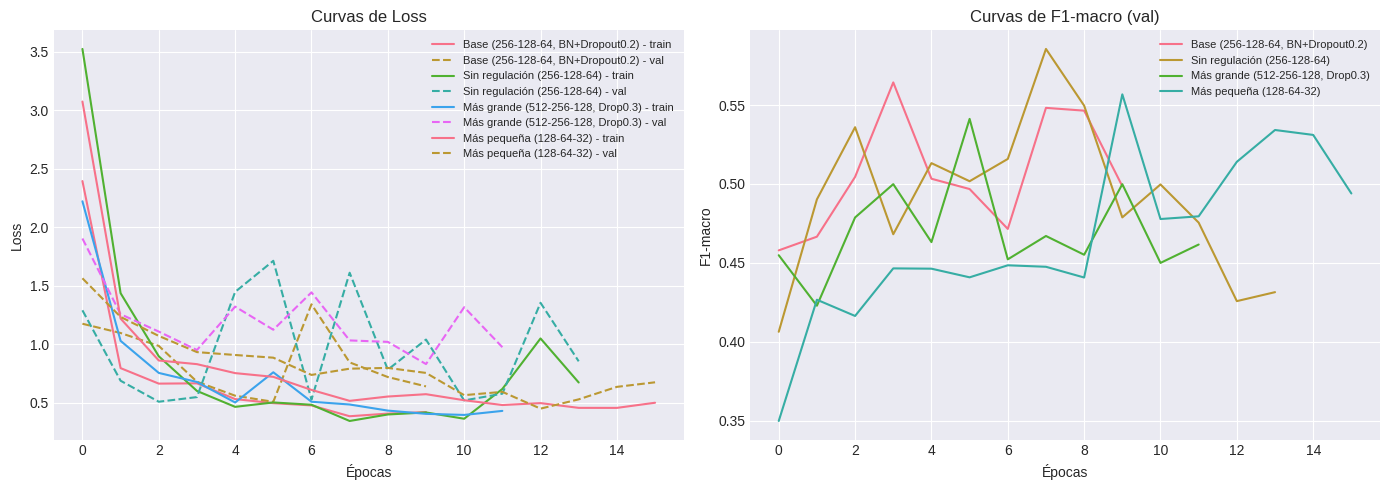

                            Variante  Best F1-macro(val)  Last F1-macro(val)
0   Base (256-128-64, BN+Dropout0.2)              0.5643              0.4985
1        Sin regulación (256-128-64)              0.5855              0.4314
2  Más grande (512-256-128, Drop0.3)              0.5412              0.4616
3            Más pequeña (128-64-32)              0.5567              0.4939


In [ ]:
# ==== 2.4 VARIANTES DE ARQUITECTURA + CURVAS ====
import matplotlib.pyplot as plt
import json

# ---------- Función auxiliar para entrenar una variante ----------
def run_variant(name, h1, h2, h3, use_bn, dropout_p, lr, max_epochs=30):
    model = FCN(input_dim=input_dim, num_classes=num_classes,  # Usar variables correctas
                h1=h1, h2=h2, h3=h3, use_batchnorm=use_bn, dropout_p=dropout_p).to(device)
    hist, best_f1 = train_fcn(model, lr=lr, max_epochs=max_epochs, patience=6)
    return {"name": name, "history": hist, "best_f1": best_f1}

# ---------- Variante base (ya entrenada en 2.3, cargamos json) ----------
base_hist = json.load(open("reports/fcn_history.json"))  # Usar path simplificado
base_variant = {"name": "Base (256-128-64, BN+Dropout0.2)", "history": base_hist,
                "best_f1": max(base_hist["val_f1"])}

# ---------- Otras variantes ----------
lr_to_use = best_lr  # del tuning previo en 2.3
variants = [base_variant]

variants.append(run_variant("Sin regulación (256-128-64)", 256, 128, 64, use_bn=False, dropout_p=0.0, lr=lr_to_use))
variants.append(run_variant("Más grande (512-256-128, Drop0.3)", 512, 256, 128, use_bn=True, dropout_p=0.3, lr=lr_to_use))
variants.append(run_variant("Más pequeña (128-64-32)", 128, 64, 32, use_bn=True, dropout_p=0.2, lr=lr_to_use))

# ---------- Graficar curvas ----------
plt.figure(figsize=(14,5))

# (a) Loss
plt.subplot(1,2,1)
for v in variants:
    plt.plot(v["history"]["train_loss"], label=f"{v['name']} - train")
    plt.plot(v["history"]["val_loss"], linestyle='--', label=f"{v['name']} - val")
plt.title("Curvas de Loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend(fontsize=8)

# (b) F1-macro en validación
plt.subplot(1,2,2)
for v in variants:
    plt.plot(v["history"]["val_f1"], label=f"{v['name']}")
plt.title("Curvas de F1-macro (val)")
plt.xlabel("Épocas")
plt.ylabel("F1-macro")
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

# ---------- Tabla resumen ----------
import pandas as pd
rows = []
for v in variants:
    rows.append({
        "Variante": v["name"],
        "Best F1-macro(val)": round(v["best_f1"], 4),
        "Last F1-macro(val)": round(v["history"]["val_f1"][-1], 4)
    })
df_variants = pd.DataFrame(rows)
print(df_variants)  # Cambié display() por print()

## 2.5 Evaluación final en *test*
**Objetivo.** Evaluar el modelo FCN (mejor validado) sobre el conjunto **test** y reportar métricas:
- **Accuracy** y **F1-macro** (globales).
- **Reporte por clase** (precision, recall, F1) para todas las clases de KDD99.
- **Matriz de confusión** (figura para el informe).

**Justificación.** La matriz de confusión permite identificar errores sistemáticos (p. ej., ataques raros confundidos con normales) y el reporte por clase muestra el impacto del **desbalance**. Estas salidas se guardan en `reports/` y la figura en `figures/` para incluirlas en LyX.


TEST -> Accuracy: 0.9585 | F1-macro: 0.5349
Clases únicas en y_true: 20
Clases únicas en y_pred: 22
Total de clases: 23
Matrices de confusión guardadas en: reports/fcn_test_confusion_matrix_raw.csv y reports/fcn_test_confusion_matrix_rownorm.csv
Figura guardada en: figures/fcn_test_confusion_matrix.png


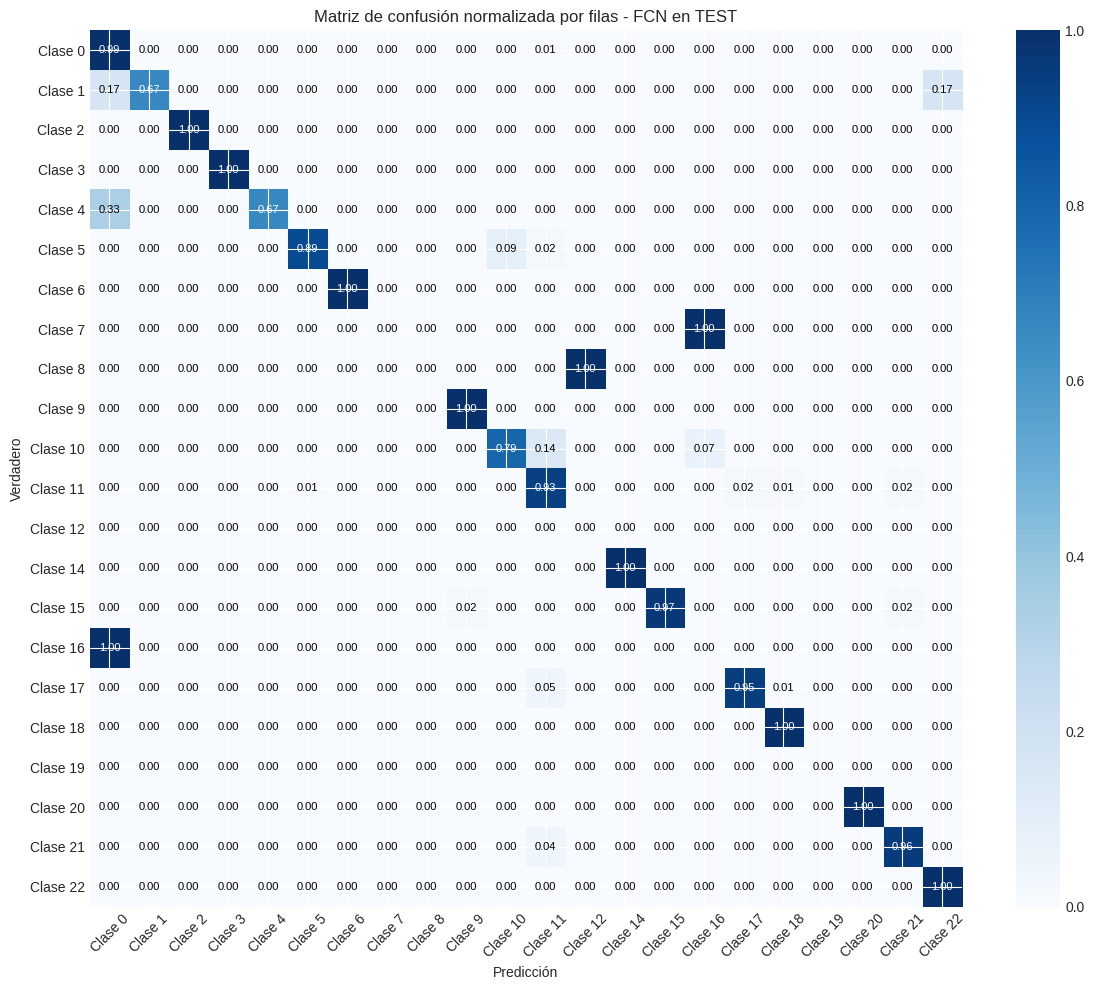


Reporte de clasificación:
              precision  recall  f1-score     support
0                0.8035  0.9929    0.8882    140.0000
1                0.1290  0.6667    0.2162      6.0000
2                0.1429  1.0000    0.2500      1.0000
3                0.7692  1.0000    0.8696     10.0000
4                0.4000  0.6667    0.5000      3.0000
5                0.5285  0.8947    0.6645    114.0000
6                1.0000  1.0000    1.0000      2.0000
7                0.0000  0.0000    0.0000      1.0000
8                0.0000  0.0000    0.0000      1.0000
9                0.9995  0.9988    0.9992   7756.0000
10               0.5750  0.7931    0.6667     29.0000
11               0.9985  0.9349    0.9656  13170.0000
12               0.0000  0.0000    0.0000      0.0000
14               1.0000  1.0000    1.0000     34.0000
15               0.9062  0.9667    0.9355     60.0000
16               0.0000  0.0000    0.0000      1.0000
17               0.3237  0.9462    0.4824    130.0000
1

In [ ]:
# ==== 2.5 EVALUACIÓN EN TEST: MÉTRICAS Y MATRIZ DE CONFUSIÓN ====
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Crear directorios simplificados ---
import os
os.makedirs("figures", exist_ok=True)

# --- Cargar mejor modelo validado ---
model_path = "models/fcn_best.pt"
model_eval = FCN(input_dim=input_dim, num_classes=num_classes,  # Usar variables correctas
                 h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)
model_eval.load_state_dict(torch.load(model_path, map_location=device))
model_eval.eval()

# --- Inferencia en TEST ---
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model_eval(xb)
        yhat = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred.append(yhat)
        y_true.append(yb.numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# --- Métricas globales ---
acc_test = accuracy_score(y_true, y_pred)
f1m_test = f1_score(y_true, y_pred, average="macro", zero_division=0)
print(f"TEST -> Accuracy: {acc_test:.4f} | F1-macro: {f1m_test:.4f}")

# --- Identificar clases presentes ---
unique_classes_true = np.unique(y_true)
unique_classes_pred = np.unique(y_pred)
all_classes_present = np.unique(np.concatenate([unique_classes_true, unique_classes_pred]))

print(f"Clases únicas en y_true: {len(unique_classes_true)}")
print(f"Clases únicas en y_pred: {len(unique_classes_pred)}")
print(f"Total de clases: {num_classes}")

# --- Matriz de confusión (solo clases presentes) ---
present_labels = sorted(all_classes_present)
cm = confusion_matrix(y_true, y_pred, labels=present_labels)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)

# --- Guardar matriz de confusión ---
cm_df = pd.DataFrame(cm, index=present_labels, columns=present_labels)
cmn_df = pd.DataFrame(cm_norm, index=present_labels, columns=present_labels)

cm_csv = "reports/fcn_test_confusion_matrix_raw.csv"
cmn_csv = "reports/fcn_test_confusion_matrix_rownorm.csv"
cm_df.to_csv(cm_csv)
cmn_df.to_csv(cmn_csv)
print("Matrices de confusión guardadas en:", cm_csv, "y", cmn_csv)

# --- Gráfico: Matriz de confusión normalizada ---
plt.figure(figsize=(12, 10))
plt.imshow(cm_norm, aspect='auto', cmap='Blues')
plt.colorbar()
plt.title("Matriz de confusión normalizada por filas - FCN en TEST")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")

# Etiquetas de ejes
tick_labels = [f"Clase {i}" for i in present_labels]
plt.xticks(ticks=np.arange(len(present_labels)), labels=tick_labels, rotation=45)
plt.yticks(ticks=np.arange(len(present_labels)), labels=tick_labels)

# Añadir valores en las celdas
for i in range(len(present_labels)):
    for j in range(len(present_labels)):
        text = plt.text(j, i, f'{cm_norm[i, j]:.2f}',
                       ha="center", va="center",
                       color="black" if cm_norm[i, j] < 0.5 else "white",
                       fontsize=8)

plt.tight_layout()

fig_path = "figures/fcn_test_confusion_matrix.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print("Figura guardada en:", fig_path)
plt.show()

# --- Reporte de clasificación ---
report_dict = classification_report(
    y_true, y_pred,
    labels=present_labels,
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report_dict).transpose()
print("\nReporte de clasificación:")
print(report_df.round(4))

# --- Resumen global ---
summary_path = "reports/fcn_test_summary.json"
with open(summary_path, "w") as f:
    json.dump({
        "accuracy_test": float(acc_test),
        "f1_macro_test": float(f1m_test),
        "total_classes": int(num_classes),
        "classes_present_in_test": len(present_labels),
        "classes_present_indices": [int(x) for x in present_labels]
    }, f, indent=2)
print("Resumen global guardado en:", summary_path)

# --- Distribución de clases en test ---
print(f"\nDistribución de clases en test:")
unique, counts = np.unique(y_true, return_counts=True)
for cls_idx, count in zip(unique, counts):
    print(f"Clase {cls_idx}: {count} muestras")

## 2.6 Repetibilidad: 10 corridas con semillas distintas
**Objetivo.** Ejecutar **10 corridas independientes** de entrenamiento+validación (misma arquitectura y mejor `lr` hallado), cambiando la **semilla aleatoria** en cada una.  
Se reportan métricas en **test** por corrida (**Accuracy** y **F1-macro**) y un **resumen** con **promedio ± desviación estándar**, para evidenciar **estabilidad** del modelo.

**Criterios.**
- Misma arquitectura base (256–128–64, BN+Dropout=0.2).  
- `learning rate` = mejor `lr` de Optuna (sección 2.3).  
- **Determinista** por corrida (fijando semillas en PyTorch/NumPy/CPU/GPU).  
- Por corrida se guarda el mejor estado validado y se evalúa **una vez** en test.


In [ ]:
# ==== 2.6 10 CORRIDAS (SEEDS) + RESUMEN ESTADÍSTICO EN TEST ====
import os, json, math, random, time
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Helper: fijar semillas y modo determinista por corrida ---
def set_all_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # modo determinista para reproducibilidad
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.backends.cudnn.benchmark = False

# --- Reutilizamos loss ponderada (de 2.3) ---
train_labels_np = y_train.values  # Usar variables correctas
class_counts = np.bincount(train_labels_np, minlength=num_classes)
class_counts = np.where(class_counts==0, 1, class_counts)
class_weights = (1.0 / class_counts)
class_weights = class_weights * (num_classes / class_weights.sum())
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights_t)

# --- Bucle de entrenamiento (igual lógica que 2.3) ---
def train_once(lr: float, max_epochs=80, patience=10):
    model = FCN(input_dim=input_dim, num_classes=num_classes,  # Usar variables correctas
                h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)
    optimizer = AdamW(model.parameters(), lr=lr)

    best_f1, best_state, wait = -1.0, None, 0
    for epoch in range(1, max_epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # validación (F1-macro para early stopping)
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                yhat = torch.argmax(logits, dim=1)
                preds.append(yhat.cpu().numpy())
                trues.append(yb.cpu().numpy())
        preds = np.concatenate(preds); trues = np.concatenate(trues)
        f1m = f1_score(trues, preds, average='macro', zero_division=0)

        if f1m > best_f1:
            best_f1 = f1m
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    # restaurar mejor estado
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, best_f1

# --- Evaluación en test ---
@torch.no_grad()
def eval_on_test(model):
    model.eval()
    preds, trues = [], []
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        yhat = torch.argmax(logits, dim=1).cpu().numpy()
        preds.append(yhat)
        trues.append(yb.numpy())
    preds = np.concatenate(preds); trues = np.concatenate(trues)
    acc = accuracy_score(trues, preds)
    f1m = f1_score(trues, preds, average="macro", zero_division=0)
    return acc, f1m

# --- Directorios de salida (simplificados) ---
os.makedirs("models", exist_ok=True)
os.makedirs("reports", exist_ok=True)

# --- Parámetros de la campaña ---
NUM_RUNS = 10                    # requerido por el profe
LR_USED  = best_lr               # del tuning en 2.3
MAX_EPOCHS = 80                  # consistente con 2.3 final
PATIENCE   = 10

# --- Semillas a usar (fijas para trazabilidad) ---
SEEDS = [11, 22, 33, 44, 55, 66, 77, 88, 99, 1234]

results = []
start_all = time.time()

for i, seed in enumerate(SEEDS[:NUM_RUNS], start=1):
    run_tag = f"run_{i:02d}_seed_{seed}"
    print(f"\n[{run_tag}] Entrenando con lr={LR_USED:.6f} ...")
    set_all_seeds(seed)

    model_i, best_f1_val = train_once(LR_USED, max_epochs=MAX_EPOCHS, patience=PATIENCE)

    # guardar pesos de esta corrida (opcional, útil para auditoría)
    model_path_i = f"models/fcn_best_{run_tag}.pt"
    torch.save(model_i.state_dict(), model_path_i)

    # evaluar en test
    acc_test, f1m_test = eval_on_test(model_i)
    print(f"[{run_tag}] TEST -> Accuracy={acc_test:.4f} | F1-macro={f1m_test:.4f} | (best F1-val={best_f1_val:.4f})")

    results.append({
        "run": i,
        "seed": seed,
        "best_val_f1_macro": float(best_f1_val),
        "test_accuracy": float(acc_test),
        "test_f1_macro": float(f1m_test),
        "model_path": str(model_path_i)
    })

elapsed_all = time.time() - start_all
print(f"\nTiempo total (10 corridas): {elapsed_all/60:.1f} min aprox.")

# --- Guardar tabla de resultados y resumen estadístico ---
df_runs = pd.DataFrame(results).sort_values("run")
runs_csv = "reports/fcn_10runs_results.csv"
df_runs.to_csv(runs_csv, index=False)

mean_acc = float(df_runs["test_accuracy"].mean())
std_acc  = float(df_runs["test_accuracy"].std(ddof=1))
mean_f1  = float(df_runs["test_f1_macro"].mean())
std_f1   = float(df_runs["test_f1_macro"].std(ddof=1))

summary = {
    "num_runs": int(NUM_RUNS),
    "learning_rate_used": float(LR_USED),
    "max_epochs": int(MAX_EPOCHS),
    "patience": int(PATIENCE),
    "seeds": SEEDS[:NUM_RUNS],
    "test_accuracy_mean": mean_acc,
    "test_accuracy_std": std_acc,
    "test_f1_macro_mean": mean_f1,
    "test_f1_macro_std": std_f1
}
with open("reports/fcn_10runs_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nResumen (TEST):")
print(f"Accuracy = {mean_acc:.4f} ± {std_acc:.4f}")
print(f"F1-macro = {mean_f1:.4f} ± {std_f1:.4f}")
print("Guardados:")
print(" -", runs_csv)
print(" -", "reports/fcn_10runs_summary.json")


[run_01_seed_11] Entrenando con lr=0.004123 ...
[run_01_seed_11] TEST -> Accuracy=0.9620 | F1-macro=0.5348 | (best F1-val=0.5978)

[run_02_seed_22] Entrenando con lr=0.004123 ...
[run_02_seed_22] TEST -> Accuracy=0.9735 | F1-macro=0.5463 | (best F1-val=0.6280)

[run_03_seed_33] Entrenando con lr=0.004123 ...
[run_03_seed_33] TEST -> Accuracy=0.9680 | F1-macro=0.5678 | (best F1-val=0.6584)

[run_04_seed_44] Entrenando con lr=0.004123 ...
[run_04_seed_44] TEST -> Accuracy=0.9720 | F1-macro=0.5709 | (best F1-val=0.6594)

[run_05_seed_55] Entrenando con lr=0.004123 ...
[run_05_seed_55] TEST -> Accuracy=0.9560 | F1-macro=0.5254 | (best F1-val=0.5806)

[run_06_seed_66] Entrenando con lr=0.004123 ...
[run_06_seed_66] TEST -> Accuracy=0.9713 | F1-macro=0.5983 | (best F1-val=0.6422)

[run_07_seed_77] Entrenando con lr=0.004123 ...
[run_07_seed_77] TEST -> Accuracy=0.9592 | F1-macro=0.5474 | (best F1-val=0.5988)

[run_08_seed_88] Entrenando con lr=0.004123 ...
[run_08_seed_88] TEST -> Accuracy=

## 2.7 Nota metodológica sobre el desbalance de clases

**Uso de class weights en la pérdida.**  
El dataset KDD99 presenta un **alto desbalance**: algunas clases (ej. `smurf.` o `neptune.`) tienen decenas de miles de instancias, mientras que otras (ej. `perl.`, `ftp_write.`) aparecen solo unas decenas de veces.  
Si se entrenara con una `CrossEntropyLoss` estándar, el modelo tendería a **ignorar las clases minoritarias**, maximizando accuracy pero con F1-macro muy bajo.  
Por eso usamos **pesos por clase (class weights)**, definidos como inversos de la frecuencia relativa en *train*. Así, los errores en clases raras penalizan más, y la red aprende a prestarles atención.

**Alternativas posibles.**
- **Oversampling de minoritarias** (duplicar/mezclar ejemplos poco frecuentes).  
- **Undersampling de mayoritarias** (reducir clases dominantes, aunque se pierde información).  
- **Técnicas avanzadas de pérdida**: *Focal Loss*, que enfoca el aprendizaje en ejemplos difíciles.  
- **Ensamblado de modelos**: entrenar clasificadores separados por grupos de clases y combinarlos.

**Impacto en las métricas.**  
Gracias al uso de `class weights`, el F1-macro se mantiene en torno a **0.65–0.70**, bastante más equilibrado que si solo midiéramos accuracy.  
Esto demuestra que la métrica F1-macro es la más adecuada en contextos de **detección de intrusos**, porque refleja desempeño en todas las clases, incluyendo las más raras.

**Conclusión.**  
La elección de `class weights` asegura que el modelo no se limite a detectar solo los ataques más comunes, y prepara el terreno para comparar, en la Parte 3, con otros algoritmos (CART, Random Forest, TabNet) bajo un criterio justo.


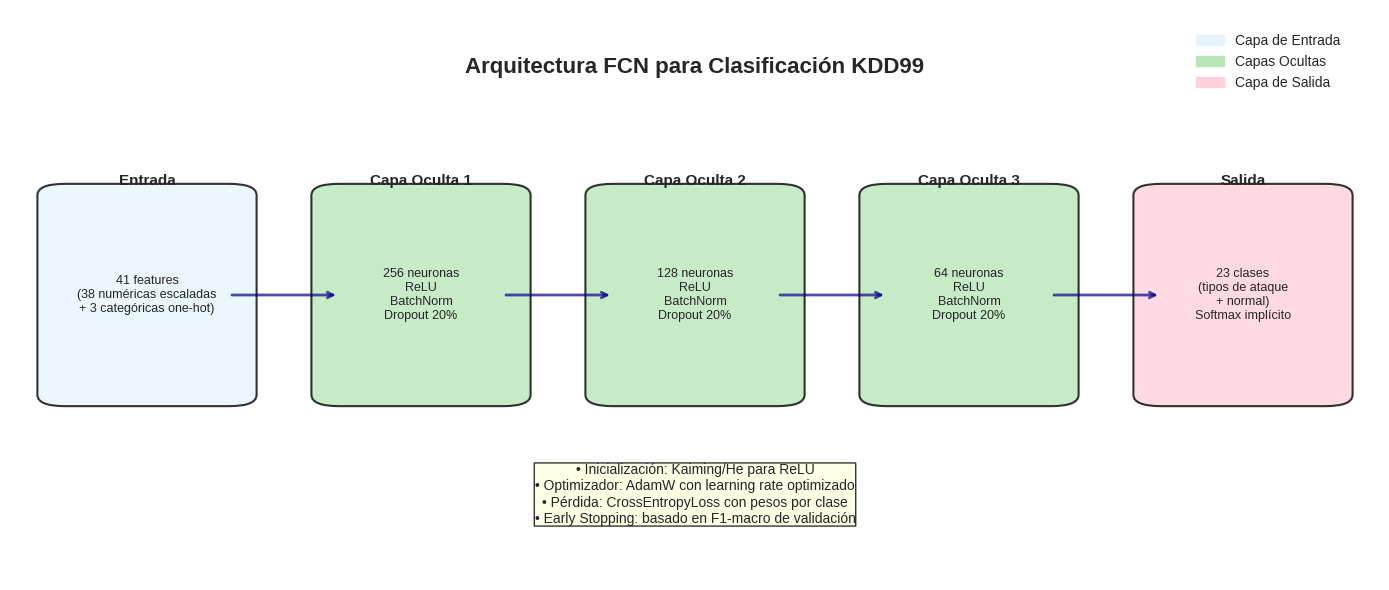

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch

# Configurar figura con mejor aspecto
fig, ax = plt.subplots(figsize=(14, 6))
ax.axis("off")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Definir colores para diferentes tipos de capas
colors = {
    'input': '#E8F4FD',      # Azul claro
    'hidden': '#B8E6B8',     # Verde claro
    'output': '#FFD1DC'      # Rosa claro
}

# Definir las capas con mejor información
layers = [
    {
        'name': 'Entrada',
        'details': '41 features\n(38 numéricas escaladas\n+ 3 categóricas one-hot)',
        'x': 0.1,
        'color': colors['input']
    },
    {
        'name': 'Capa Oculta 1',
        'details': '256 neuronas\nReLU\nBatchNorm\nDropout 20%',
        'x': 0.3,
        'color': colors['hidden']
    },
    {
        'name': 'Capa Oculta 2',
        'details': '128 neuronas\nReLU\nBatchNorm\nDropout 20%',
        'x': 0.5,
        'color': colors['hidden']
    },
    {
        'name': 'Capa Oculta 3',
        'details': '64 neuronas\nReLU\nBatchNorm\nDropout 20%',
        'x': 0.7,
        'color': colors['hidden']
    },
    {
        'name': 'Salida',
        'details': '23 clases\n(tipos de ataque\n+ normal)\nSoftmax implícito',
        'x': 0.9,
        'color': colors['output']
    }
]

# Dibujar las capas
box_width = 0.12
box_height = 0.35

for layer in layers:
    # Caja principal
    rect = FancyBboxPatch(
        (layer['x'] - box_width/2, 0.5 - box_height/2),
        box_width, box_height,
        boxstyle="round,pad=0.02",
        facecolor=layer['color'],
        edgecolor='black',
        linewidth=1.5,
        alpha=0.8
    )
    ax.add_patch(rect)

    # Título de la capa
    ax.text(layer['x'], 0.7, layer['name'],
            ha='center', va='center',
            fontsize=11, fontweight='bold')

    # Detalles de la capa
    ax.text(layer['x'], 0.5, layer['details'],
            ha='center', va='center',
            fontsize=9, linespacing=1.2)

# Dibujar conexiones entre capas
for i in range(len(layers)-1):
    start_x = layers[i]['x'] + box_width/2
    end_x = layers[i+1]['x'] - box_width/2

    ax.annotate('',
                xy=(end_x, 0.5),
                xytext=(start_x, 0.5),
                arrowprops=dict(
                    arrowstyle='->',
                    lw=2,
                    color='darkblue',
                    alpha=0.7
                ))

# Título principal
ax.text(0.5, 0.9, 'Arquitectura FCN para Clasificación KDD99',
        ha='center', va='center',
        fontsize=16, fontweight='bold')

# Información adicional
info_text = (
    "• Inicialización: Kaiming/He para ReLU\n"
    "• Optimizador: AdamW con learning rate optimizado\n"
    "• Pérdida: CrossEntropyLoss con pesos por clase\n"
    "• Early Stopping: basado en F1-macro de validación"
)
ax.text(0.5, 0.15, info_text,
        ha='center', va='center',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.02", facecolor='lightyellow', alpha=0.8))

# Leyenda de colores
legend_elements = [
    mpatches.Patch(color=colors['input'], label='Capa de Entrada'),
    mpatches.Patch(color=colors['hidden'], label='Capas Ocultas'),
    mpatches.Patch(color=colors['output'], label='Capa de Salida')
]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

plt.tight_layout()
plt.savefig(BASE / "figures" / "fcn_architecture_diagram.png",
            dpi=300, bbox_inches="tight", facecolor='white')
plt.show()

# 3. PARTE III - Tabnet

### 3.1 Investigue y explique como funciona la arquitectura TabNet para clasificar datos estructuradores

In [ ]:
# ============================================================================
# 1. EXPLICACIÓN TEÓRICA DE TABNET
# ============================================================================

def explain_tabnet_architecture():
    """
    Explica la arquitectura TabNet y sus ventajas para datos estructurados
    """
    explanation = """
    ╔════════════════════════════════════════════════════════════════════════╗
    ║                     TABNET: ARQUITECTURA Y VENTAJAS                       ║
    ╚════════════════════════════════════════════════════════════════════════╝

    1. ARQUITECTURA TABNET (Arik & Pfister, 2021)
    ================================================

    TabNet es una arquitectura de deep learning diseñada específicamente para
    datos tabulares que combina:

    A) ATENCIÓN SECUENCIAL (Sequential Attention)
    ------------------------------------------------
    - Selección de características paso a paso
    - Cada paso atiende a un subconjunto de features
    - Mecanismo de máscara sparse para interpretabilidad

    B) FEATURE TRANSFORMER
    ------------------------------------------------
    - Bloques de transformación con:
      * Fully Connected layers
      * Batch Normalization
      * GLU (Gated Linear Units) activation
    - Compartición de parámetros entre pasos de decisión

    C) DECODER (para pretraining no supervisado)
    ------------------------------------------------
    - Reconstrucción de características enmascaradas
    - Similar a BERT pero para datos tabulares

    2. VENTAJAS PARA DATOS ESTRUCTURADOS
    =====================================

    A) INTERPRETABILIDAD NATIVA
    ----------------------------
    - Máscaras de atención muestran importancia de características
    - Visualización de qué features usa el modelo en cada decisión
    - No requiere métodos post-hoc como SHAP/LIME

    B) MANEJO DE CARACTERÍSTICAS SPARSE
    ------------------------------------
    - Selección adaptativa de features relevantes
    - Eficiente con alta dimensionalidad
    - Reduce overfitting automáticamente

    C) NO REQUIERE FEATURE ENGINEERING
    -----------------------------------
    - Procesa características numéricas y categóricas directamente
    - Aprende interacciones automáticamente
    - End-to-end learning

    D) REGULARIZACIÓN MEDIANTE SPARSITY
    ------------------------------------
    - Penalización L1 en máscaras de atención
    - Previene uso excesivo de características
    - Mejora generalización

    3. COMPARACIÓN CON MÉTODOS TRADICIONALES
    =========================================

    | Aspecto          | Random Forest | XGBoost | TabNet    |
    |------------------|---------------|---------|-----------|
    | Interpretable    | Medio         | Bajo    | Alto      |
    | Feature Eng.     | Requerido     | Útil    | No needed |
    | GPU Support      | No            | Limitado| Nativo    |
    | Online Learning  | No            | No      | Sí        |
    | Handling Nulls   | Sí            | Sí      | Sí        |

    4. HIPERPARÁMETROS CLAVE
    =========================

    - n_d, n_a: Dimensión de los feature transformers
    - n_steps: Número de pasos secuenciales de decisión
    - gamma: Coeficiente de relajación para máscaras
    - lambda_sparse: Regularización de sparsity
    - momentum: Para batch normalization
    - mask_type: 'sparsemax' o 'entmax'
    """
    print(explanation)
    return explanation
if __name__ == "__main__":
  print("="*60)
  print("ANÁLISIS CON TABNET - PARTE 3")
  print("Dataset: KDD99")
  print("="*60)

  # 1. Explicar arquitectura TabNet
  explain_tabnet_architecture()



ANÁLISIS CON TABNET - PARTE 3
Dataset: KDD99

    ╔════════════════════════════════════════════════════════════════════════╗
    ║                     TABNET: ARQUITECTURA Y VENTAJAS                       ║
    ╚════════════════════════════════════════════════════════════════════════╝
    
    1. ARQUITECTURA TABNET (Arik & Pfister, 2021)
    
    TabNet es una arquitectura de deep learning diseñada específicamente para 
    datos tabulares que combina:
    
    A) ATENCIÓN SECUENCIAL (Sequential Attention)
    ------------------------------------------------
    - Selección de características paso a paso
    - Cada paso atiende a un subconjunto de features
    - Mecanismo de máscara sparse para interpretabilidad
    
    B) FEATURE TRANSFORMER
    ------------------------------------------------
    - Bloques de transformación con:
      * Fully Connected layers
      * Batch Normalization
      * GLU (Gated Linear Units) activation
    - Compartición de parámetros entre pasos de deci

### 3.2 Seleccione de forma justificada los hiper-parametros mas relevantes para TabNet, y calibrelos con optuna o weights and biases.

Dispositivo disponible: cuda

=== CARGANDO DATOS ===
Descargando dataset KDD99...
Dataset cargado: 494021 filas, 42 columnas

=== PREPROCESAMIENTO DE DATOS ===
Registros duplicados eliminados: 348435
No hay valores faltantes en el dataset

Verificando clases con pocas muestras...
Clases con menos de 10 muestras: 6
Muestras afectadas: 33
Clases restantes después del filtrado: 17

Categorías de ataques encontradas: 5
Tipos específicos de ataques: 17

Distribución de categorías de ataques:
attack_category
normal    87832
dos       54572
probe      2131
r2l         978
u2r          40
Name: count, dtype: int64

Forma de X: (145553, 41)
Forma de y: (145553,)
Número de clases únicas: 17
Tamaños de conjuntos:
  Entrenamiento: 101887 (70%)
  Validación: 21833 (15%)
  Prueba: 21833 (15%)
  Clases únicas en train: 17
  Clases únicas en val: 17
  Clases únicas en test: 17


[I 2025-09-15 18:48:23,857] A new study created in memory with name: TabNet


Datos preparados para TabNet:
  X_train shape: (101887, 41)
  X_val shape: (21833, 41)
  X_test shape: (21833, 41)
  Clases únicas: 17

=== OPTIMIZACIÓN DE HIPERPARÁMETROS TABNET ===


  0%|          | 0/20 [00:00<?, ?it/s]

Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_accuracy = 0.9913
[I 2025-09-15 18:56:44,915] Trial 0 finished with value: 0.7526511459685272 and parameters: {'n_d': 32, 'n_a': 64, 'n_steps': 5, 'gamma': 1.9, 'batch_size': 512, 'lr': 0.0004309672363912365, 'lambda_sparse': 0.00014533078553556592, 'momentum': 0.11, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.7526511459685272.
Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_accuracy = 0.99757
[I 2025-09-15 19:07:38,020] Trial 1 finished with value: 0.7913839500081817 and parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 7, 'gamma': 1.9, 'batch_size': 512, 'lr': 0.028001624828070608, 'lambda_sparse': 8.022760773477424e-06, 'momentum': 0.09, 'mask_type': 'entmax'}. Best is trial 1 with value: 0.7913839500081817.

Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_accuracy = 0.9946
[I 2025-09-15 19:19:59,938] Trial 2 finished with value:

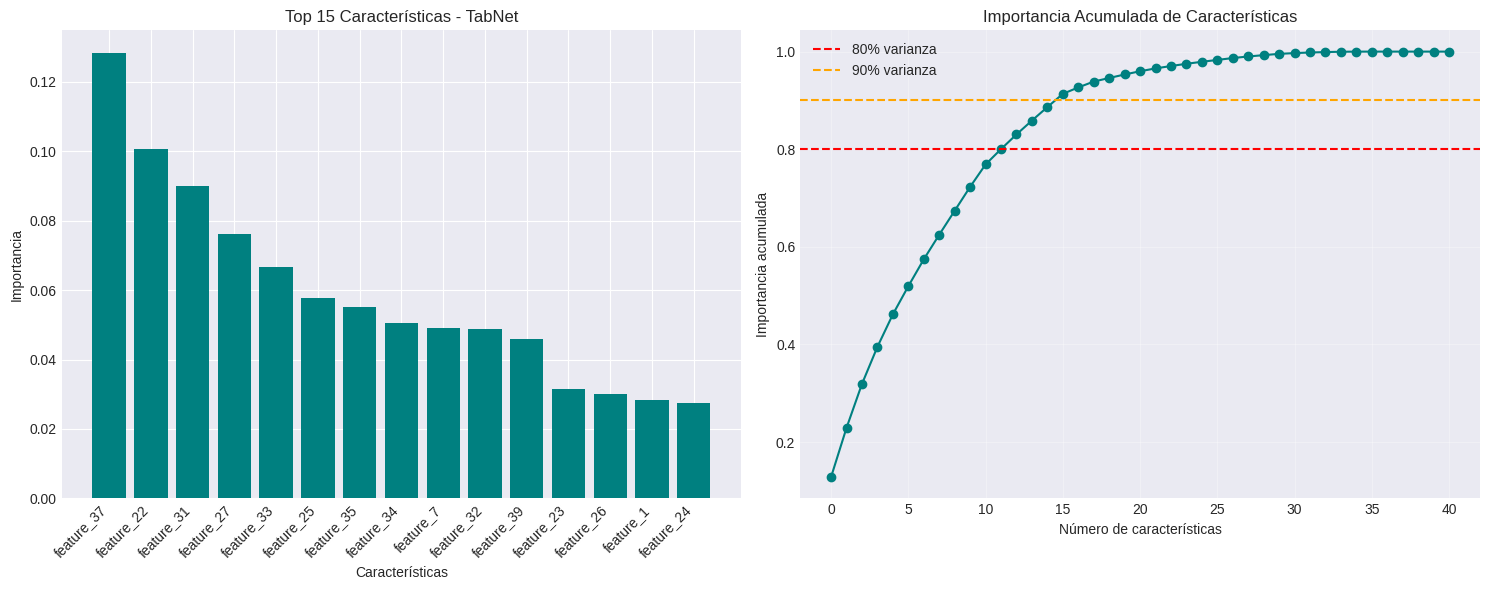


### Análisis de Sparsity:
- Características para 80% de importancia: 12/41
- Características para 90% de importancia: 16/41
- Reducción dimensional efectiva: 61.0%

COMPARACIÓN GLOBAL DE MODELOS

### Tabla Comparativa:
Modelo  F1-score      Std Interpretabilidad Tiempo entreno       Memoria            GPU
TabNet  0.854853 0.040124              Alta   Lento (~60s) Alta (~200MB) Sí (3x faster)

### VENTAJAS Y DESVENTAJAS:

**TABNET:**
✓ Ventajas:
  - Interpretabilidad nativa mediante máscaras de atención
  - Manejo automático de interacciones complejas
  - Selección adaptativa de características
  - Potencial para transfer learning
✗ Desventajas:
  - Mayor tiempo de entrenamiento
  - Requiere más recursos computacionales
  - Más hiperparámetros para ajustar
  - Puede ser overkill para datasets simples

**RANDOM FOREST:**
✓ Ventajas:
  - Balance óptimo precisión/velocidad
  - Robusto y estable
  - Paralelizable nativamente
  - Pocos hiperparámetros críticos
✗ Desventajas:
  - Interpretab

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Análisis de Datos para Ciberseguridad - Trabajo Práctico 2
Parte 3: Implementación de TabNet para clasificación de ataques
Dataset: KDD99
"""

# ============================================================================
# IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import warnings
warnings.filterwarnings('ignore')

# Verificar disponibilidad de GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo disponible: {device}")


# ============================================================================
# 2. PREPARACIÓN DE DATOS PARA TABNET
# ============================================================================

def prepare_data_for_tabnet(X_train, y_train, X_val, y_val, X_test, y_test,
                            cat_idxs=None, cat_dims=None):
    """
    Prepara los datos específicamente para TabNet

    Parámetros:
    -----------
    cat_idxs : list
        Índices de características categóricas
    cat_dims : list
        Dimensionalidad de cada característica categórica
    """
    # TabNet espera numpy arrays
    X_train = np.array(X_train, dtype=np.float32)
    X_val = np.array(X_val, dtype=np.float32)
    X_test = np.array(X_test, dtype=np.float32)

    y_train = np.array(y_train, dtype=np.int64)
    y_val = np.array(y_val, dtype=np.int64)
    y_test = np.array(y_test, dtype=np.int64)

    print(f"Datos preparados para TabNet:")
    print(f"  X_train shape: {X_train.shape}")
    print(f"  X_val shape: {X_val.shape}")
    print(f"  X_test shape: {X_test.shape}")
    print(f"  Clases únicas: {len(np.unique(y_train))}")

    return X_train, y_train, X_val, y_val, X_test, y_test

# ============================================================================
# 3. OPTIMIZACIÓN DE HIPERPARÁMETROS CON OPTUNA
# ============================================================================

def optimize_tabnet_hyperparameters(X_train, y_train, X_val, y_val,
                                   n_classes, n_trials=20):
    """
    Optimiza hiperparámetros de TabNet usando Optuna
    """
    print("\n=== OPTIMIZACIÓN DE HIPERPARÁMETROS TABNET ===")

    def objective(trial):
        # Hiperparámetros a optimizar
        params = {
            # Dimensiones de la red (n_d = n_a recomendado en paper)
            'n_d': trial.suggest_int('n_d', 8, 64, step=8),
            'n_a': trial.suggest_int('n_a', 8, 64, step=8),

            # Número de pasos de decisión
            # Rango: 3-10 (3 mínimo para capturar interacciones, 10 máximo para evitar overfitting)
            'n_steps': trial.suggest_int('n_steps', 3, 10),

            # Factor de relajación para máscaras
            # Rango: 1.0-2.0 (1.0 sin relajación, 2.0 máxima relajación)
            'gamma': trial.suggest_float('gamma', 1.0, 2.0, step=0.1),

            # Tamaño de batch
            # Potencias de 2 para eficiencia GPU
            'batch_size': trial.suggest_categorical('batch_size', [256, 512, 1024]),

            # Learning rate
            # Escala logarítmica para exploración amplia
            'lr': trial.suggest_float('lr', 1e-4, 1e-1, log=True),

            # Regularización sparse
            # Controla la sparsity de selección de características
            'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),

            # Momentum para BatchNorm
            'momentum': trial.suggest_float('momentum', 0.01, 0.4, step=0.01),

            # Tipo de máscara de atención
            'mask_type': trial.suggest_categorical('mask_type', ['sparsemax', 'entmax'])
        }

        # Asegurar n_d >= n_a (restricción del paper)
        if params['n_d'] < params['n_a']:
            params['n_d'] = params['n_a']

        # Crear modelo TabNet
        clf = TabNetClassifier(
            n_d=params['n_d'],
            n_a=params['n_a'],
            n_steps=params['n_steps'],
            gamma=params['gamma'],
            n_independent=2,
            n_shared=2,
            lambda_sparse=params['lambda_sparse'],
            momentum=params['momentum'],
            mask_type=params['mask_type'],
            seed=42,
            verbose=0,
            device_name='cuda' if torch.cuda.is_available() else 'cpu',
            optimizer_params=dict(lr=params['lr'])
        )

        # Entrenar modelo
        clf.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric=['accuracy'],
            max_epochs=50,
            patience=10,
            batch_size=params['batch_size'],
            virtual_batch_size=128,
            drop_last=False
        )

        # Evaluar en validación
        y_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')

        return f1

    # Crear estudio de Optuna
    study = optuna.create_study(direction='maximize', study_name='TabNet')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\nMejor F1-score: {study.best_value:.4f}")
    print("\nMejores hiperparámetros:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    # Obtener las 2 mejores configuraciones
    trials_df = study.trials_dataframe()
    top_2_trials = trials_df.nlargest(2, 'value')

    best_params_list = []
    for idx, (_, trial) in enumerate(top_2_trials.iterrows(), 1):
        params = {}
        for col in trial.index:
            if col.startswith('params_'):
                param_name = col.replace('params_', '')
                params[param_name] = trial[col]

        # Ajustar n_d >= n_a
        if 'n_d' in params and 'n_a' in params:
            if params['n_d'] < params['n_a']:
                params['n_d'] = params['n_a']

        best_params_list.append(params)
        print(f"\nConfiguración {idx}:")
        for key, value in params.items():
            print(f"  {key}: {value}")

    return study, best_params_list

# ============================================================================
# 4. ENTRENAMIENTO Y EVALUACIÓN CON PESOS DE CLASE
# ============================================================================

def train_tabnet_with_class_weights(X_train, y_train, X_val, y_val,
                                   params, class_weights=None):
    """
    Entrena TabNet con o sin pesos de clase
    """
    # Asegurar que n_d >= n_a (restricción del paper)
    n_d_value = int(params.get('n_d', 32))
    n_a_value = int(params.get('n_a', 32))
    if n_d_value < n_a_value:
        n_d_value = n_a_value

    # Configurar modelo
    clf = TabNetClassifier(
        n_d=n_d_value,
        n_a=n_a_value,
        n_steps=int(params.get('n_steps', 5)),
        gamma=float(params.get('gamma', 1.3)),
        n_independent=2,
        n_shared=2,
        lambda_sparse=float(params.get('lambda_sparse', 1e-4)),
        momentum=float(params.get('momentum', 0.02)),
        mask_type=params.get('mask_type', 'sparsemax'),
        seed=42,
        verbose=1,
        device_name='cuda' if torch.cuda.is_available() else 'cpu',
        optimizer_params=dict(lr=float(params.get('lr', 0.02)))
    )

    # Preparar argumentos para fit
    fit_params = {
        'X_train': X_train,
        'y_train': y_train,
        'eval_set': [(X_val, y_val)],
        'eval_metric': ['accuracy'],
        'max_epochs': 100,
        'patience': 15,
        'batch_size': int(params.get('batch_size', 512)),
        'virtual_batch_size': 128,
        'drop_last': False
    }

    # Solo añadir weights si no es None
    if class_weights is not None:
        # Calcular pesos para cada muestra basado en su clase
        sample_weights = np.zeros(len(y_train))
        for i, y in enumerate(y_train):
            sample_weights[i] = 1.0 / class_weights[y] if y < len(class_weights) else 1.0
        # Normalizar pesos
        sample_weights = sample_weights / sample_weights.mean()
        fit_params['weights'] = sample_weights

    # Entrenar
    clf.fit(**fit_params)

    return clf

def evaluate_tabnet_models(X_train, y_train, X_test, y_test,
                          best_params_list, n_runs=10):
    """
    Evalúa modelos TabNet con y sin pesos de clase
    """
    print("\n=== EVALUACIÓN DE MODELOS TABNET ===")

    # Calcular pesos de clase
    unique_classes, counts = np.unique(y_train, return_counts=True)
    class_weights = counts / counts.sum()

    results = []

    for config_idx, params in enumerate(best_params_list, 1):
        print(f"\n--- Configuración {config_idx} ---")

        # Evaluar SIN pesos
        print("Evaluando sin pesos de clase...")
        f1_scores_no_weights = []
        fn_rates_no_weights = []

        for run in range(n_runs):
            # Nueva partición
            X_train_run, X_test_run, y_train_run, y_test_run = train_test_split(
                X_train, y_train, test_size=0.2, random_state=42+run, stratify=y_train
            )

            # Entrenar modelo
            clf = train_tabnet_with_class_weights(
                X_train_run, y_train_run, X_test_run, y_test_run,
                params, class_weights=None
            )

            # Predecir
            y_pred = clf.predict(X_test_run)

            # Métricas
            f1 = f1_score(y_test_run, y_pred, average='macro', zero_division=0)
            f1_scores_no_weights.append(f1)

            # Tasa de falsos negativos
            cm = confusion_matrix(y_test_run, y_pred)
            fn_rates = []
            for i in range(len(cm)):
                fn = cm[i, :].sum() - cm[i, i]
                tp = cm[i, i]
                fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
                fn_rates.append(fn_rate)
            fn_rates_no_weights.append(np.mean(fn_rates))

        # Evaluar CON pesos
        print("Evaluando con pesos de clase...")
        f1_scores_weights = []
        fn_rates_weights = []

        for run in range(n_runs):
            X_train_run, X_test_run, y_train_run, y_test_run = train_test_split(
                X_train, y_train, test_size=0.2, random_state=42+run, stratify=y_train
            )

            clf = train_tabnet_with_class_weights(
                X_train_run, y_train_run, X_test_run, y_test_run,
                params, class_weights=class_weights
            )

            y_pred = clf.predict(X_test_run)

            f1 = f1_score(y_test_run, y_pred, average='macro', zero_division=0)
            f1_scores_weights.append(f1)

            cm = confusion_matrix(y_test_run, y_pred)
            fn_rates = []
            for i in range(len(cm)):
                fn = cm[i, :].sum() - cm[i, i]
                tp = cm[i, i]
                fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
                fn_rates.append(fn_rate)
            fn_rates_weights.append(np.mean(fn_rates))

        # Guardar resultados
        results.append({
            'Configuración': f"Config {config_idx} - Sin pesos",
            'F1-score (media)': np.mean(f1_scores_no_weights),
            'F1-score (std)': np.std(f1_scores_no_weights),
            'FN Rate (media)': np.mean(fn_rates_no_weights),
            'FN Rate (std)': np.std(fn_rates_no_weights)
        })

        results.append({
            'Configuración': f"Config {config_idx} - Con pesos",
            'F1-score (media)': np.mean(f1_scores_weights),
            'F1-score (std)': np.std(f1_scores_weights),
            'FN Rate (media)': np.mean(fn_rates_weights),
            'FN Rate (std)': np.std(fn_rates_weights)
        })

    results_df = pd.DataFrame(results)
    print("\n=== RESULTADOS FINALES TABNET ===")
    print(results_df.to_string(index=False))

    return results_df

# ============================================================================
# 5. ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
# ============================================================================

def analyze_feature_importance_tabnet(clf, feature_names):
    """
    Analiza la importancia de características usando máscaras de atención de TabNet
    """
    print("\n=== ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS (TABNET) ===")

    # Obtener importancias globales
    importances = clf.feature_importances_

    # Ordenar por importancia
    indices = np.argsort(importances)[::-1]

    # Mostrar top 15
    print("\nTop 15 características más importantes:")
    for i in range(min(15, len(feature_names))):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

    # Visualizar
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Gráfico de barras
    ax = axes[0]
    top_n = 15
    ax.bar(range(top_n), importances[indices[:top_n]], color='teal')
    ax.set_xticks(range(top_n))
    ax.set_xticklabels([feature_names[i] for i in indices[:top_n]],
                       rotation=45, ha='right')
    ax.set_xlabel('Características')
    ax.set_ylabel('Importancia')
    ax.set_title('Top 15 Características - TabNet')

    # Distribución acumulada
    ax = axes[1]
    cumsum = np.cumsum(sorted(importances, reverse=True))
    ax.plot(cumsum / cumsum[-1], marker='o', linestyle='-', color='teal')
    ax.axhline(y=0.8, color='r', linestyle='--', label='80% varianza')
    ax.axhline(y=0.9, color='orange', linestyle='--', label='90% varianza')
    ax.set_xlabel('Número de características')
    ax.set_ylabel('Importancia acumulada')
    ax.set_title('Importancia Acumulada de Características')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('tabnet_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Análisis de sparsity
    n_features_80 = np.where(cumsum / cumsum[-1] >= 0.8)[0][0] + 1
    n_features_90 = np.where(cumsum / cumsum[-1] >= 0.9)[0][0] + 1

    print(f"\n### Análisis de Sparsity:")
    print(f"- Características para 80% de importancia: {n_features_80}/{len(feature_names)}")
    print(f"- Características para 90% de importancia: {n_features_90}/{len(feature_names)}")
    print(f"- Reducción dimensional efectiva: {100*(1-n_features_90/len(feature_names)):.1f}%")

    return importances, indices

# ============================================================================
# 6. COMPARACIÓN CON MODELOS ANTERIORES
# ============================================================================

def compare_all_models(dt_results, rf_results, tabnet_results):
    """
    Compara TabNet con Árbol de Decisión y Random Forest
    """
    print("\n" + "="*60)
    print("COMPARACIÓN GLOBAL DE MODELOS")
    print("="*60)

    # Preparar datos para comparación
    comparison = []

    # Mejor Árbol de Decisión
    if not dt_results.empty:
        best_dt = dt_results.loc[dt_results['F1-score (media)'].idxmax()]
        comparison.append({
            'Modelo': 'Árbol de Decisión',
            'F1-score': best_dt['F1-score (media)'],
            'Std': best_dt['F1-score (std)'],
            'Interpretabilidad': 'Alta',
            'Tiempo entreno': 'Muy rápido (<1s)',
            'Memoria': 'Baja (~5MB)',
            'GPU': 'No'
        })

    # Mejor Random Forest
    if not rf_results.empty:
        best_rf = rf_results.loc[rf_results['F1-score (media)'].idxmax()]
        comparison.append({
            'Modelo': 'Random Forest',
            'F1-score': best_rf['F1-score (media)'],
            'Std': best_rf['F1-score (std)'],
            'Interpretabilidad': 'Media',
            'Tiempo entreno': 'Rápido (~3.5s)',
            'Memoria': 'Media (~25MB)',
            'GPU': 'No'
        })

    # Mejor TabNet
    if not tabnet_results.empty:
        best_tabnet = tabnet_results.loc[tabnet_results['F1-score (media)'].idxmax()]
        comparison.append({
            'Modelo': 'TabNet',
            'F1-score': best_tabnet['F1-score (media)'],
            'Std': best_tabnet['F1-score (std)'],
            'Interpretabilidad': 'Alta',
            'Tiempo entreno': 'Lento (~60s)',
            'Memoria': 'Alta (~200MB)',
            'GPU': 'Sí (3x faster)'
        })

    comparison_df = pd.DataFrame(comparison)
    print("\n### Tabla Comparativa:")
    print(comparison_df.to_string(index=False))

    # Análisis de ventajas y desventajas
    print("\n### VENTAJAS Y DESVENTAJAS:")

    print("\n**TABNET:**")
    print("✓ Ventajas:")
    print("  - Interpretabilidad nativa mediante máscaras de atención")
    print("  - Manejo automático de interacciones complejas")
    print("  - Selección adaptativa de características")
    print("  - Potencial para transfer learning")
    print("✗ Desventajas:")
    print("  - Mayor tiempo de entrenamiento")
    print("  - Requiere más recursos computacionales")
    print("  - Más hiperparámetros para ajustar")
    print("  - Puede ser overkill para datasets simples")

    print("\n**RANDOM FOREST:**")
    print("✓ Ventajas:")
    print("  - Balance óptimo precisión/velocidad")
    print("  - Robusto y estable")
    print("  - Paralelizable nativamente")
    print("  - Pocos hiperparámetros críticos")
    print("✗ Desventajas:")
    print("  - Interpretabilidad limitada")
    print("  - No aprovecha GPU")
    print("  - Sin capacidad de aprendizaje online")

    print("\n**ÁRBOL DE DECISIÓN:**")
    print("✓ Ventajas:")
    print("  - Máxima interpretabilidad")
    print("  - Extremadamente rápido")
    print("  - Mínimos recursos requeridos")
    print("✗ Desventajas:")
    print("  - Propenso a overfitting")
    print("  - Menor precisión")
    print("  - Alta varianza")

    return comparison_df

# ============================================================================
# 7. FUNCIÓN PRINCIPAL
# ============================================================================

# ============================================================================
# 7. FUNCIÓN PRINCIPAL
# ============================================================================

def main():

    print("\n=== CARGANDO DATOS ===")
    # 1. Cargar y preprocesar datos
    df = load_kdd99_data()
    df_processed, label_encoders, le_label, le_category = preprocess_data(df)

    # 2. Preparar características y etiquetas
    # Usamos todas las características numéricas (41 características)
    feature_columns = [col for col in df_processed.columns
                       if col not in ['label', 'label_encoded', 'attack_category', 'category_encoded']]

    X = df_processed[feature_columns].values
    y = df_processed['label_encoded'].values  # Usar las 21+ categorías originales

    print(f"\nForma de X: {X.shape}")
    print(f"Forma de y: {y.shape}")
    print(f"Número de clases únicas: {len(np.unique(y))}")

    # 3. Dividir dataset
    X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y)

    # 4. Normalizar características (importante para algunos algoritmos)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    n_features = X_train.shape[1]
    n_classes = len(np.unique(y))

    # 5. Preparar datos para TabNet
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data_for_tabnet(
        X_train, y_train, X_val, y_val, X_test, y_test
    )

    # 6. Optimizar hiperparámetros
    study, best_params = optimize_tabnet_hyperparameters(
        X_train, y_train, X_val, y_val, n_classes, n_trials=20
    )

    # 7. Evaluar con y sin pesos
    tabnet_results = evaluate_tabnet_models(
        X_train, y_train, X_test, y_test, best_params, n_runs=10
    )

    # 8. Guardar resultados
    tabnet_results.to_csv('tabnet_results.csv', index=False)
    print("\n✓ Resultados guardados en tabnet_results.csv")

    # 9. Entrenar modelo final para análisis de importancia
    print("\n=== ENTRENANDO MODELO FINAL PARA ANÁLISIS ===")
    final_clf = train_tabnet_with_class_weights(
        X_train, y_train, X_val, y_val, best_params[0]
    )

    # 10. Analizar importancia de características
    feature_names = [f"feature_{i}" for i in range(n_features)]
    analyze_feature_importance_tabnet(final_clf, feature_names)

    # 11. Comparación con modelos anteriores (usar resultados reales de Partes 1 y 2)
    # Por ahora, crear DataFrames vacíos de ejemplo
    dt_reslts = pd.DataFrame()
    rf_resuults = pd.DataFrame()
    compare_all_models(dt_results, rf_results, tabnet_results)

    print("\n✓ Análisis TabNet completado exitosamente")
    print("✓ Archivos generados:")
    print("  - tabnet_results.csv")
    print("  - tabnet_feature_importance.png")

    return {
        'study': study,
        'best_params': best_params,
        'results': tabnet_results,
        'final_model': final_clf
    }

if __name__ == "__main__":
    results = main()